In [1]:
import sys
sys.path.append(r'/hr-fs02/hr_projekte/Pol-InSAR_InfoRetrieval/10_users/mans_is/PyPolSAR')

In [2]:
import rioxarray
import rasterio as rio
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box, mapping
from scipy import ndimage
from pypolsar import geo
import pprint


In [3]:
import h5py

from pypolsar import polsar
import matplotlib.pyplot as plt

from pypolsar import utils, plot
from pypolsar import polsar
from pypolsar.polsar import decomposition

from pypolsar.stats.timer import Timer
from pathlib import Path
import pypolsar

import seaborn as sns
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap


In [4]:
fig_save = Path("./../figures/")

In [5]:
from pathlib import Path

process_path = Path('./../data/processed/')
# p = Path('./')
prmasr_nc = {}
prmasr_nc["L"] = {}
prmasr_nc["S"] = {}
prmasr_nc["L"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*L.nc')))
prmasr_nc["L"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*L.nc')))
prmasr_nc["S"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*S.nc')))
prmasr_nc["S"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*S.nc')))
prmasr_nc

{'L': {'18': [PosixPath('../data/processed/ecological_masks/18prmasr0302_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0303_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0304_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0305_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0306_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0307_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0308_L.nc')],
  '19': [PosixPath('../data/processed/ecological_masks/19prmasr1002_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1003_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1004_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1006_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1007_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1008_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1009_L.nc')]},


In [6]:

colors_hex = ["#4DB65B", "#425DAA", "#F1EB58", "#A4AA56", "#49B0AD", "#A95052", "#74C044"]
color_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']

ecological_colors = {}
for name, color_hex in zip(color_names, colors_hex):
    ecological_colors[name] = matplotlib.colors.to_rgb(color_hex)
    
print(ecological_colors)


{'Avadlek': (0.30196078431372547, 0.7137254901960784, 0.3568627450980392), 'Guillemot': (0.25882352941176473, 0.36470588235294116, 0.6666666666666666), 'Herschel': (0.9450980392156862, 0.9215686274509803, 0.34509803921568627), 'Komakuk': (0.6431372549019608, 0.6666666666666666, 0.33725490196078434), 'Orca': (0.28627450980392155, 0.6901960784313725, 0.6784313725490196), 'Plove+Jae': (0.6627450980392157, 0.3137254901960784, 0.3215686274509804), 'Thrasher': (0.4549019607843137, 0.7529411764705882, 0.26666666666666666)}


In [7]:
def combine_netcdf(path_18, path_19, clip=None):
    ds_1 = xr.open_dataset(path_18)
    ds_2 = xr.open_dataset(path_19)

    ds_con = xr.concat([ds_1, ds_2], dim=pd.Index([2018, 2019], name='time'))
    ds_con = ds_con.where(ds_con.mask_valid == 1) 
    if clip is not None:
        ds_con = clip_raster_with_shp(ds_con, shapefile= shapefile_clip)
    
    return ds_con

In [ ]:
ds_l = combine_netcdf(prmasr_nc["L"]["18"][0], prmasr_nc["L"]["19"][1])
ds_s = combine_netcdf(prmasr_nc["S"]["18"][0], prmasr_nc["S"]["19"][1])
ds_l["offnadir"] = np.rad2deg(ds_l["offnadir"])
ds_s["offnadir"] = np.rad2deg(ds_s["offnadir"])
ds_l["aoi"] = np.rad2deg(ds_l["aoi"])
ds_s["aoi"] = np.rad2deg(ds_s["aoi"])

In [44]:
ds_s

<xarray.Dataset>
Dimensions:          (band: 1, time: 2, x: 5360, y: 10150)
Coordinates:
    mask_valid       (time, y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    mask_Avadlek     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Guillemot   (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Herschel    (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Komakuk     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
    mask_Orca        (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Plove_+Jae  (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Thrasher    (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * y                (y) float64 7.726e+06 7.726e+06 ... 7.716e+06 7.716e+06
  * x                (x) float64 5.675e+05 5.675e+05 ... 5.729e+05 5.729e+05
  * band             (band) int32 1
    wavelength       (time, band) float64 0.09083 0.09082
    spatial_ref      int32 0
  * time             (time) int64 2018 2019
Data variables:
    offnadir         (time, band, y, x) float32 nan nan nan nan ... nan nan nan
    entropy          (time, band, y, x) float64 nan nan nan nan ... nan nan nan
    anisotropy       (time, band, y, x) float64 nan nan nan nan ... nan nan nan
    alpha            (time, band, y, x) float64 nan nan nan nan ... nan nan nan
    p_hhvv           (time, band, y, x) float32 nan nan nan nan ... nan nan nan
    ph_diff_hhvv     (time, band, y, x) float32 nan nan nan nan ... nan nan nan
    aoi              (time, band, y, x) float32 nan nan nan nan ... nan nan nan

In [89]:
( ds_s['ph_diff_hhvv'].data[:,:,:])

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)

In [90]:
ds_1.drop('offnadir')

<xarray.Dataset>
Dimensions:          (band: 1, x: 5355, y: 9420)
Coordinates:
    mask_valid       (y, x) int8 ...
    mask_Avadlek     (y, x) int8 ...
    mask_Guillemot   (y, x) int8 ...
    mask_Herschel    (y, x) int8 ...
    mask_Komakuk     (y, x) int8 ...
    mask_Orca        (y, x) int8 ...
    mask_Plove_+Jae  (y, x) int8 ...
    mask_Thrasher    (y, x) int8 ...
  * y                (y) float64 7.725e+06 7.725e+06 ... 7.716e+06 7.716e+06
  * x                (x) float64 5.675e+05 5.675e+05 ... 5.729e+05 5.729e+05
  * band             (band) int32 1
    wavelength       (band) float64 ...
    spatial_ref      int32 ...
Data variables:
    entropy          (band, y, x) float64 ...
    anisotropy       (band, y, x) float64 ...
    alpha            (band, y, x) float64 ...
    p_hhvv           (band, y, x) float32 ...
    ph_diff_hhvv     (band, y, x) float32 ...
    aoi              (band, y, x) float32 ...

In [73]:
path_18 = prmasr_nc["L"]["18"][0]
ds_1 = xr.open_dataset(path_18)

In [92]:
ds_1.drop('offnadir').rio.reproject('epsg:4326',resampling=Resampling.bilinear)


ValueError: IndexVariable objects must be 1-dimensional

In [72]:
from rasterio.enums import Resampling

ds_l.rio.reproject('epsg:4326',resampling=Resampling.bilinear)
 # "epsg:4326"


TooManyDimensions: Only 2D and 3D data arrays supported. Data variable: offnadir

In [53]:
ds_l_df

offnadir  entropy  anisotropy  alpha  \
band time x             y                                                    
1    2018 567539.538173 7.725448e+06       NaN      NaN         NaN    NaN   
                        7.725447e+06       NaN      NaN         NaN    NaN   
                        7.725446e+06       NaN      NaN         NaN    NaN   
                        7.725445e+06       NaN      NaN         NaN    NaN   
                        7.725444e+06       NaN      NaN         NaN    NaN   
...                                        ...      ...         ...    ...   
     2019 572893.538173 7.716033e+06       NaN      NaN         NaN    NaN   
                        7.716032e+06       NaN      NaN         NaN    NaN   
                        7.716031e+06       NaN      NaN         NaN    NaN   
                        7.716030e+06       NaN      NaN         NaN    NaN   
                        7.716029e+06       NaN      NaN         NaN    NaN   

                                      p_hhvv  ph_diff_hhvv  aoi  mask_valid  \
band time x             y                                                     
1    2018 567539.538173 7.725448e+06     NaN           NaN  NaN           0   
                        7.725447e+06     NaN           NaN  NaN           0   
                        7.725446e+06     NaN           NaN  NaN           0   
                        7.725445e+06     NaN           NaN  NaN           0   
                        7.725444e+06     NaN           NaN  NaN           0   
...                                      ...           ...  ...         ...   
     2019 572893.538173 7.716033e+06     NaN           NaN  NaN           0   
                        7.716032e+06     NaN           NaN  NaN           0   
                        7.716031e+06     NaN           NaN  NaN           0   
                        7.716030e+06     NaN           NaN  NaN           0   
                        7.716029e+06     NaN           NaN  NaN           0   

                                      mask_Avadlek  mask_Guillemot  \
band time x             y                                            
1    2018 567539.538173 7.725448e+06             0               0   
                        7.725447e+06             0               0   
                        7.725446e+06             0               0   
                        7.725445e+06             0               0   
                        7.725444e+06             0               0   
...                                            ...             ...   
     2019 572893.538173 7.716033e+06             0               0   
                        7.716032e+06             0               0   
                        7.716031e+06             0               0   
                        7.716030e+06             0               0   
                        7.716029e+06             0               0   

                                      mask_Herschel  mask_Komakuk  mask_Orca  \
band time x             y                                                      
1    2018 567539.538173 7.725448e+06              0             0          0   
                        7.725447e+06              0             0          0   
                        7.725446e+06              0             0          0   
                        7.725445e+06              0             0          0   
                        7.725444e+06              0             0          0   
...                                             ...           ...        ...   
     2019 572893.538173 7.716033e+06              0             1          0   
                        7.716032e+06              0             1          0   
                        7.716031e+06              0             1          0   
                        7.716030e+06              0             1          0   
                        7.716029e+06              0             1          0   

                                      mask_

<AxesSubplot:xlabel='offnadir_avg', ylabel='entropy_avg'>

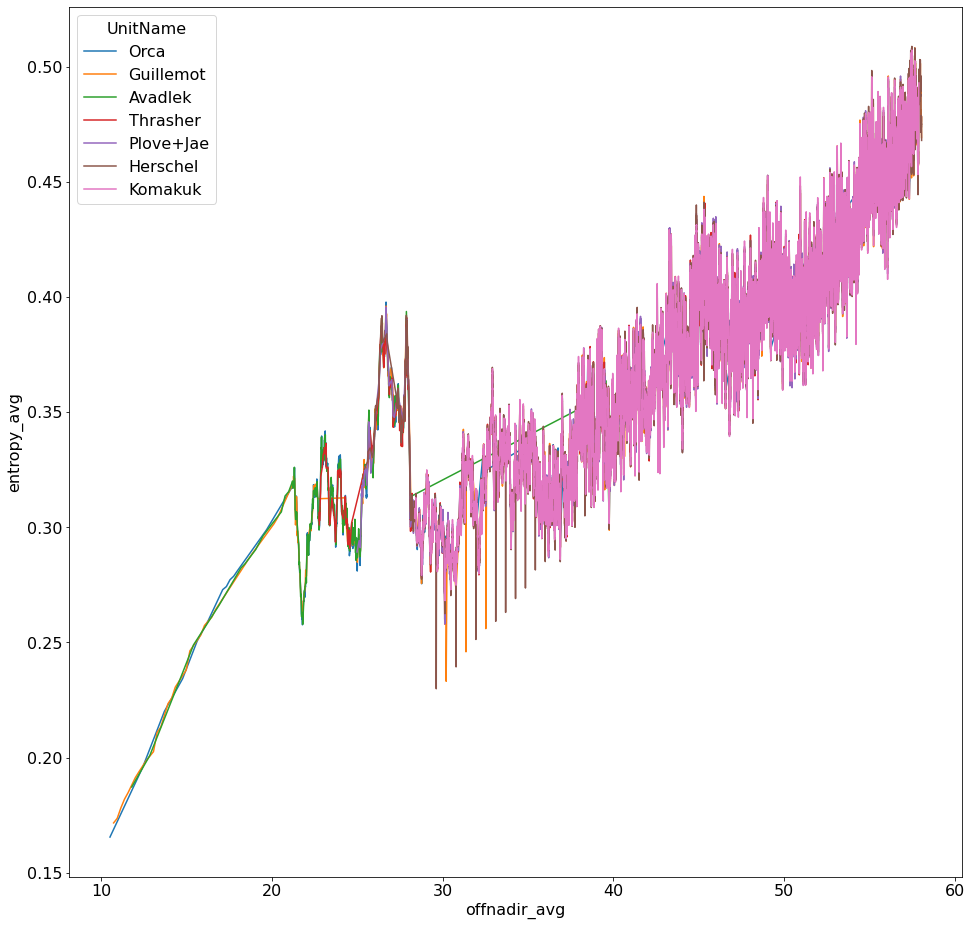

In [70]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w
filtered_df = ds_l_df.reset_index().dropna().sample(100000).sort_values(by=['offnadir'])
filtered_df['offnadir_avg'] = moving_average(filtered_df['offnadir'], 100)
filtered_df['entropy_avg'] = moving_average(filtered_df['entropy'], 100)


sns.lineplot(data=filtered_df, x='offnadir_avg',y='entropy_avg',err_style='bars', hue='UnitName')

<AxesSubplot:xlabel='offnadir', ylabel='entropy'>

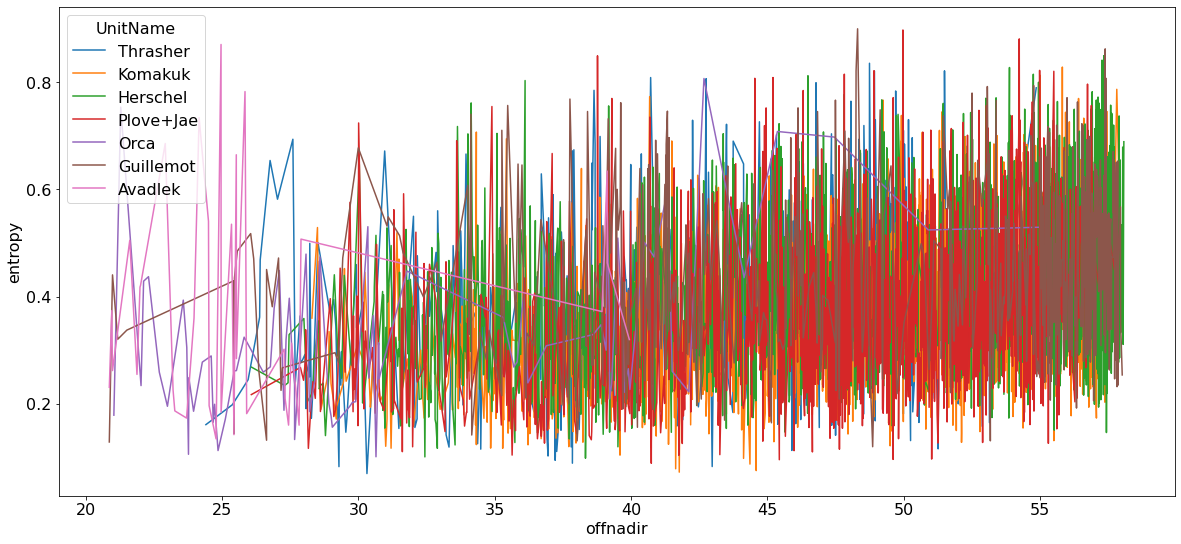

In [58]:
plt.figure(figsize=(20,9))
sns.lineplot(data = ds_l_df.reset_index().sample(10000), x='offnadir',y='entropy',err_style='bars', hue='UnitName')

<AxesSubplot:xlabel='UnitName', ylabel='entropy'>

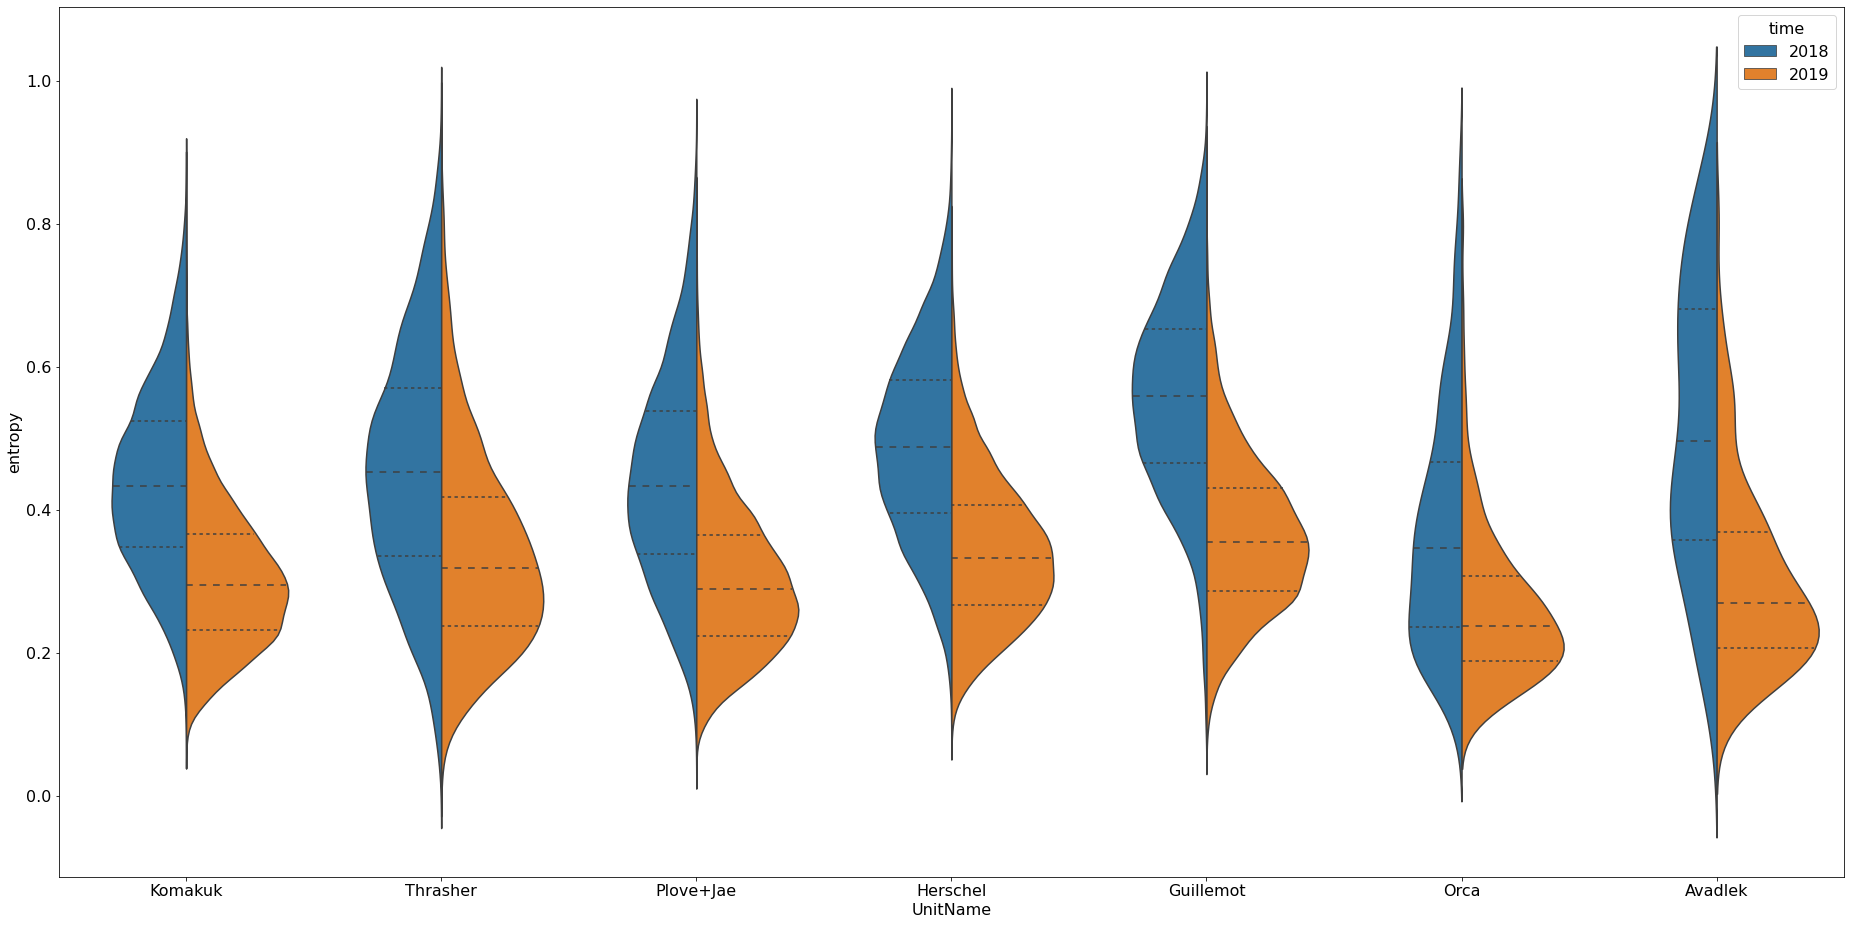

In [68]:
filtered_df = ds_l_df.reset_index().dropna().sample(100000)
# Figure
fig, ax = plt.subplots(1, figsize=(32,16), facecolor='white')
# Plot
sns.violinplot(x="UnitName", y="entropy", hue="time",
               split=True, inner="quart",
               data=filtered_df)

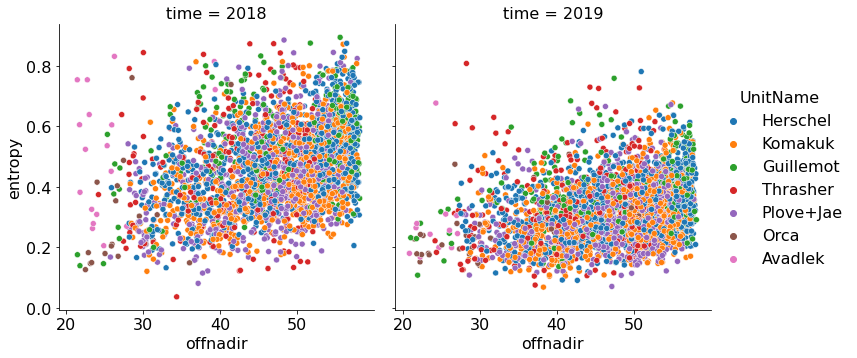

In [56]:

sns.relplot(
    data=ds_l_df.reindex().sample(10000), x="offnadir", y="entropy",
    col="time", hue="UnitName",
)


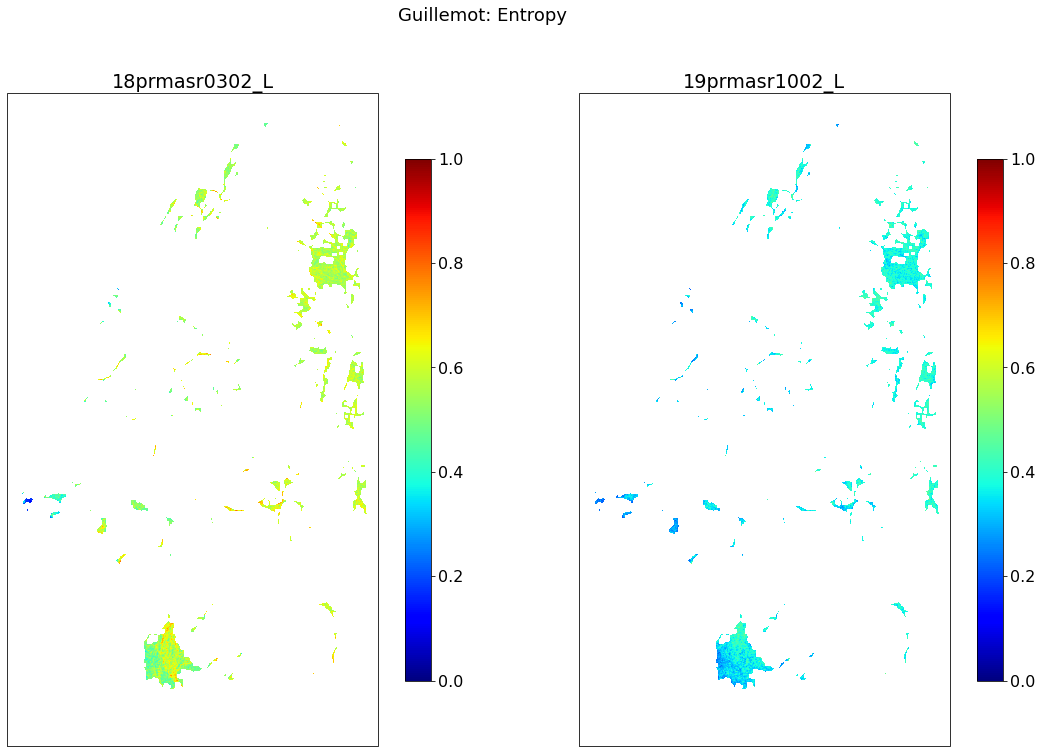

In [45]:
def plot_mask_images(path_18, path_19, save_path=None, extent=None, mask='mask_Guillemot'):
    from cartopy import crs as ccrs
    from pyproj import Transformer
    from rasterio.enums import Resampling

    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

    
    pol_key = []
    pol_key.append("entropy"   )
    #pol_key.append("anisotropy" )
    #pol_key.append("alpha"      )
    #pol_key.append("p_hhvv"     )
    #pol_key.append("ph_diff_hhvv")
    # "epsg:4326"
    ds_1 = xr.open_dataset(path_18)# .rio.reproject('epsg:3857',resampling=Resampling.bilinear)
    ds_2 = xr.open_dataset(path_19)# .rio.reproject('epsg:3857',resampling=Resampling.bilinear)

    ds_con = xr.concat([ds_1, ds_2], dim=pd.Index([2018, 2019], name='time'))
    ds_con = ds_con.where(ds_con.mask_valid == 1) 
    ds_con = ds_con
    crs_epsg = ccrs.epsg(ds_con.rio.crs.to_epsg())
    # transformer = Transformer.from_crs(4326, ds_con.rio.crs.to_epsg())
    for item in pol_key:
        # print(item)
        img_extend = ds_con.rio.bounds()
        fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.epsg(ds_con.rio.crs.to_epsg())},
                                figsize=(5*2*2, 6*2*1)) 
        
        ax_1 = axs[0]
        ax_2 = axs[1]

        img_1 = ds_con[item][ds_con.time == 2018].where((ds_con[mask] == True)).data[0, 0, :, :]
        img_2 = ds_con[item][ds_con.time == 2019].where((ds_con[mask] == True)).data[0, 0, :, :]

        if item == "entropy" or item == "anisotropy":
            vmin_1 = 0
            vmax_1 = 1
        #"""        
        elif item == 'alpha':
            vmin_1 = 0
            vmax_1 = 50
        # """
        elif item == 'p_hhvv':
            vmin_1 = 0.5
            vmax_1 = 1.8
        #""" 
        elif item == 'ph_diff_hhvv':
            vmin_1 = -20
            vmax_1 = 40
        #"""
        else:
            vmin_1, vmax_1 = np.nanpercentile(img_1, [2, 98])

        ax_cc_1 = ax_1.imshow(img_1, origin='upper', transform=ccrs.epsg(ds_con.rio.crs.to_epsg()), 
                  cmap="jet", vmin=vmin_1, vmax=vmax_1,
                  extent=[img_extend[0], img_extend[2], img_extend[1], img_extend[3]])
        fig.colorbar(ax_cc_1, ax=ax_1, shrink=0.8, orientation="vertical",)
                    # ticks=colorbar_ticks(vmin_1, vmax_1))


        im_perc = np.nanpercentile(img_2, [5, 95])
        ax_cc_2 = ax_2.imshow(img_2, origin='upper', transform=ccrs.epsg(ds_con.rio.crs.to_epsg()), 
                  cmap="jet", vmin=vmin_1, vmax=vmax_1,
                  extent=[img_extend[0], img_extend[2], img_extend[1], img_extend[3]])
        fig.colorbar(ax_cc_2, ax=ax_2, shrink=0.8, orientation="vertical",)
                    # ticks=colorbar_ticks(vmin_1, vmax_1))

       
        
        plt.subplots_adjust(wspace=0.05, hspace=0.1)
        fig.suptitle(mask[5:] + ": " + item.title() , fontsize=18)
        ax_1.set_title(path_18.name[:-3] )
        ax_2.set_title(path_19.name[:-3] )

        # ax_1.set_axis_off()
        # ax_2.set_axis_off()

        # ax_1.xlabels_top = False
        # ax_1.ylabels_right = False
        # ax_1.xlines = False
        # ax_1.xformatter = LONGITUDE_FORMATTER
        # ax_1.yformatter = LATITUDE_FORMATTER


        if save_path is not None:
            fig.savefig(save_path.joinpath( mask + '_' + path_18.name[:-3]+ "_" + path_19.name[:-3]  + "_" + item +".png"))
            plt.clf()
   



In [46]:
unit_masks = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove_+Jae', 'Thrasher']

for path_18, path_19 in zip( prmasr_nc["S"]["18"][0:], prmasr_nc["S"]["19"][0:]):
    fig_save_name = fig_save.joinpath("./PNG/", "./pol_classes/")
    
    for unit_mask in unit_masks:
        plot_mask_images(path_18=path_18, path_19=path_19, save_path=fig_save_name, extent=None, mask='mask_'+unit_mask)

<ipython-input-45-eb6261bf7ce5>:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.epsg(ds_con.rio.crs.to_epsg())},


<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

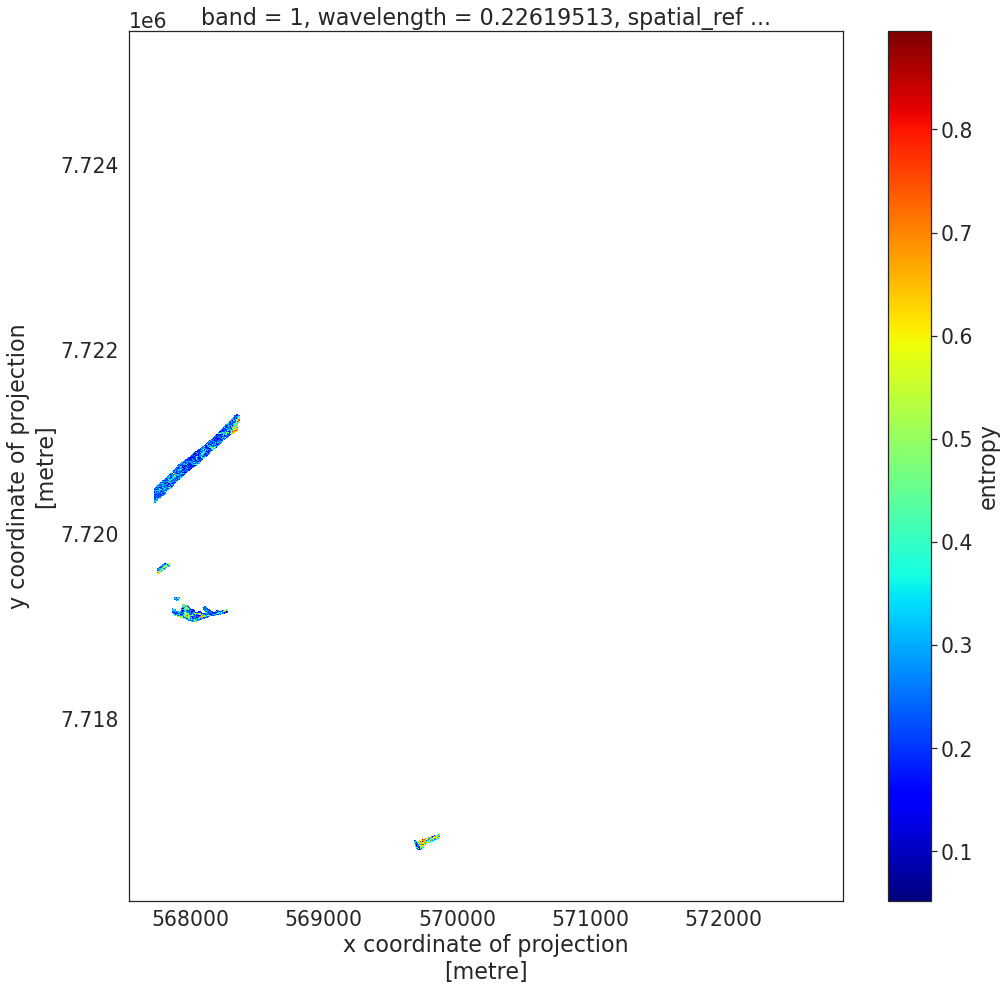

In [185]:
ds_l.where((ds_l['mask_Avadlek'] == True)).entropy.sel(time=2019).plot(cmap='jet')

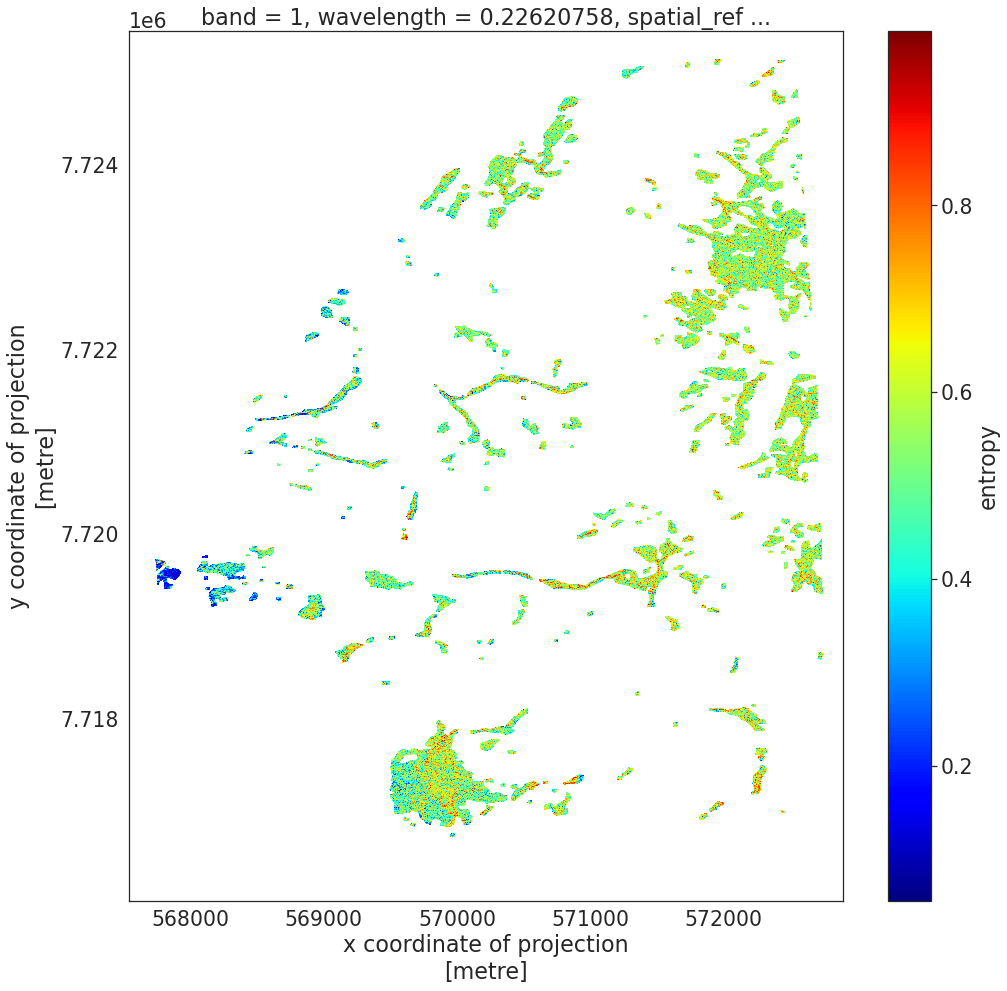

In [186]:
ds_l.where((ds_l['mask_Guillemot'] == True)).entropy.sel(time=2018).plot(cmap='jet')

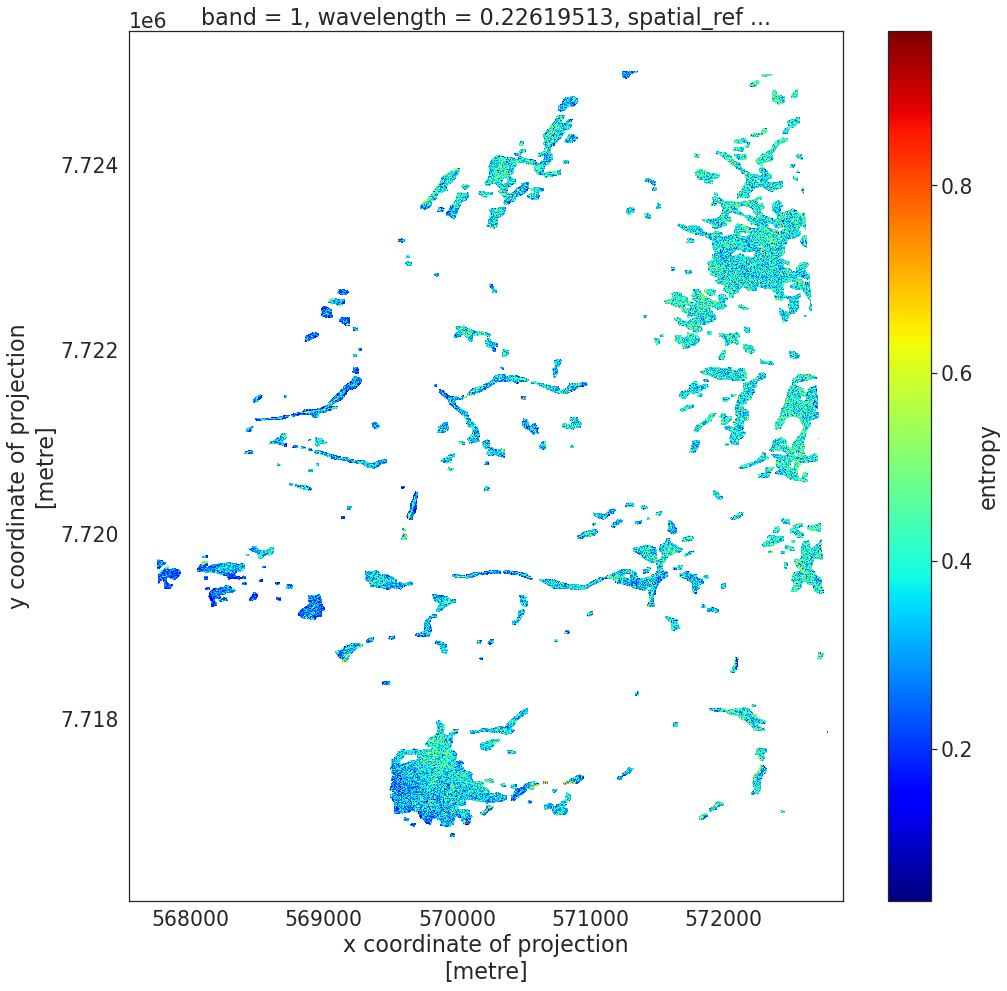

In [187]:
ds_l.where((ds_l['mask_Guillemot'] == True)).entropy.sel(time=2019).plot(cmap='jet')

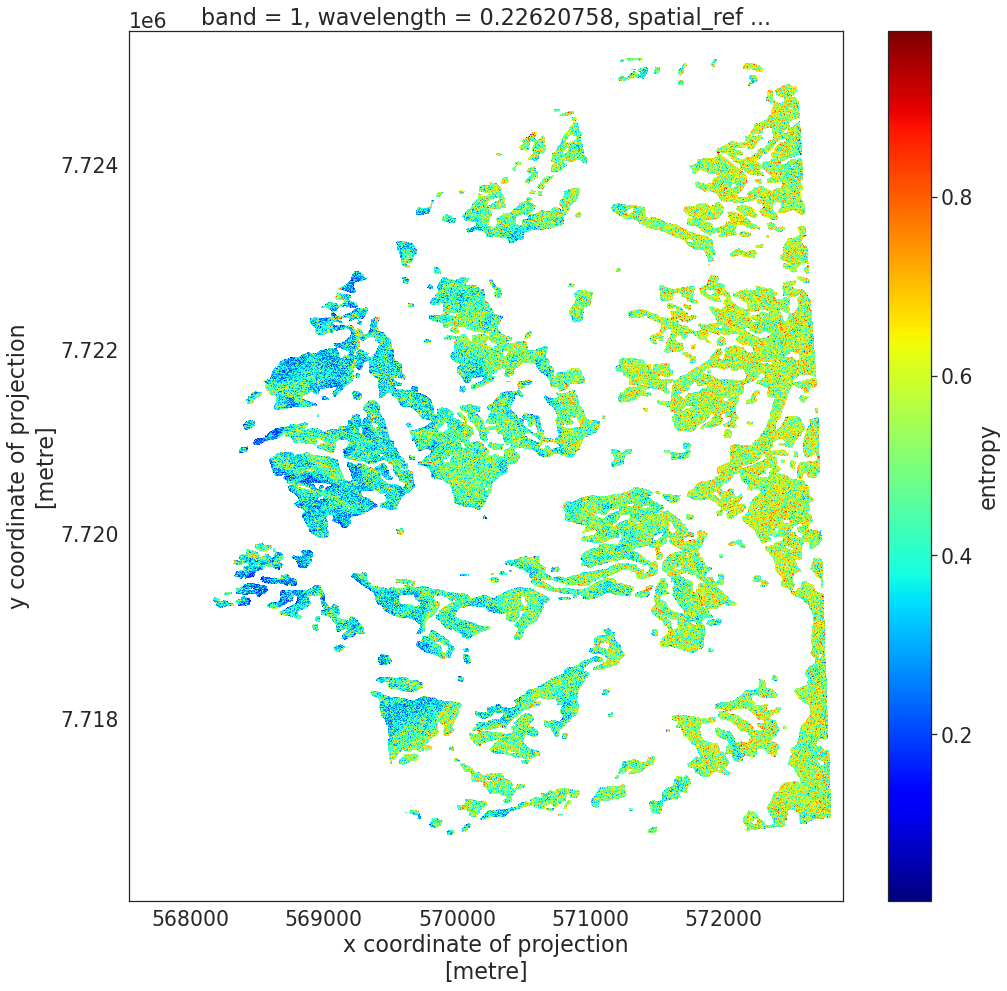

In [188]:
ds_l.where((ds_l['mask_Herschel'] == True)).entropy.sel(time=2018).plot(cmap='jet')

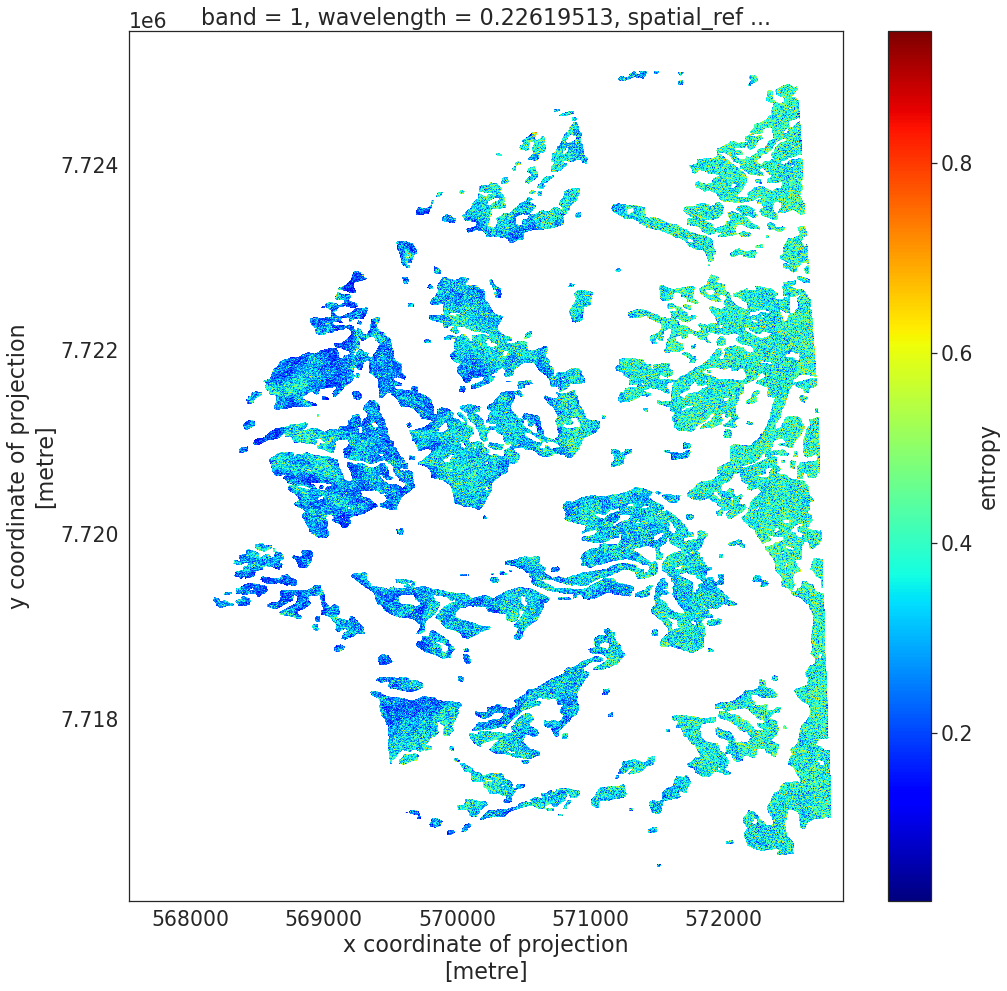

In [189]:
ds_l.where((ds_l['mask_Herschel'] == True)).entropy.sel(time=2019).plot(cmap='jet')

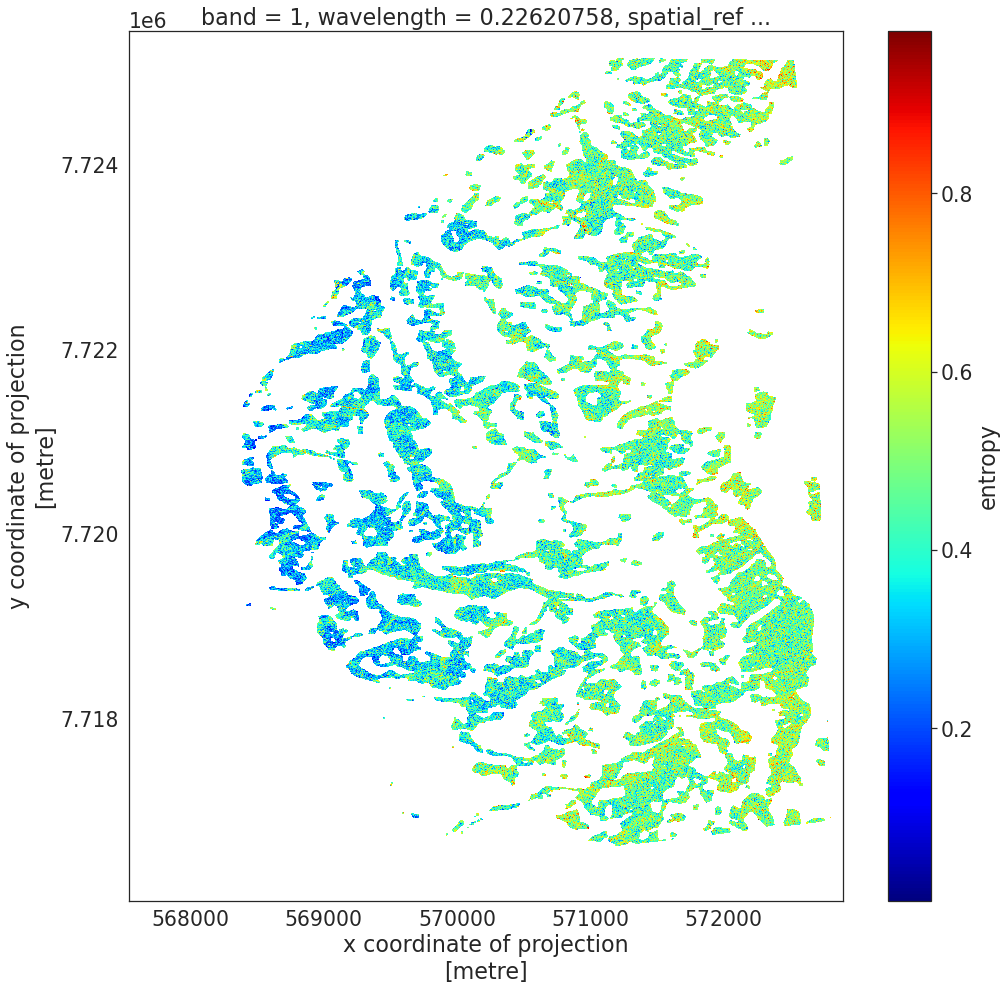

In [190]:
ds_l.where((ds_l['mask_Komakuk'] == True)).entropy.sel(time=2018).plot(cmap='jet')

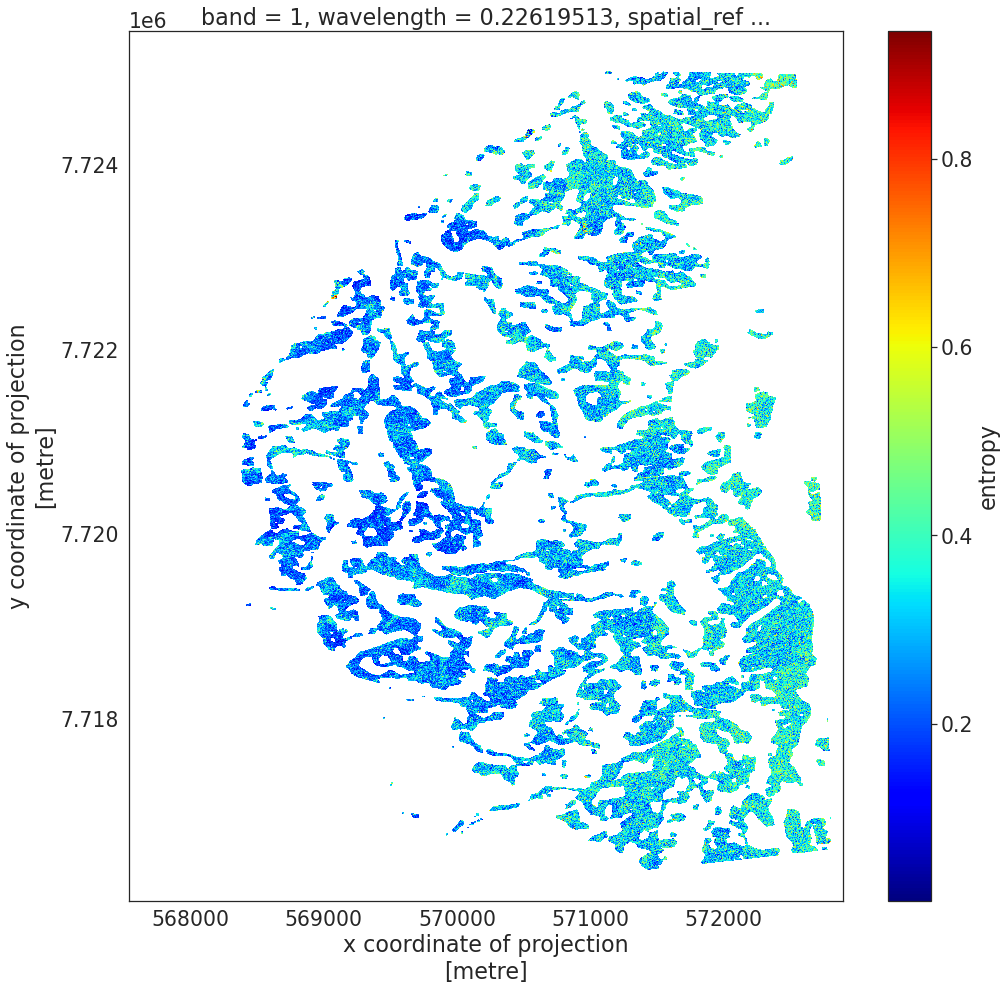

In [191]:
ds_l.where((ds_l['mask_Komakuk'] == True)).entropy.sel(time=2019).plot(cmap='jet')

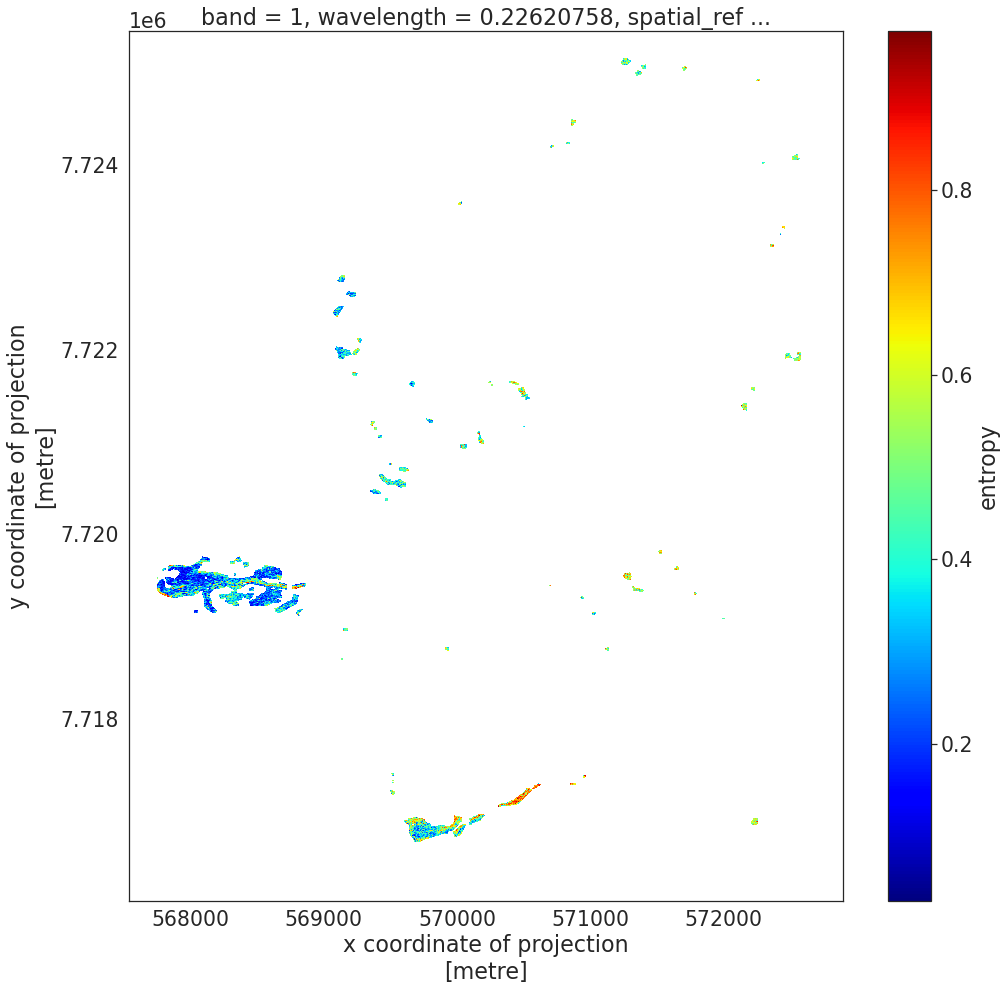

In [192]:
ds_l.where((ds_l['mask_Orca'] == True)).entropy.sel(time=2018).plot(cmap='jet')

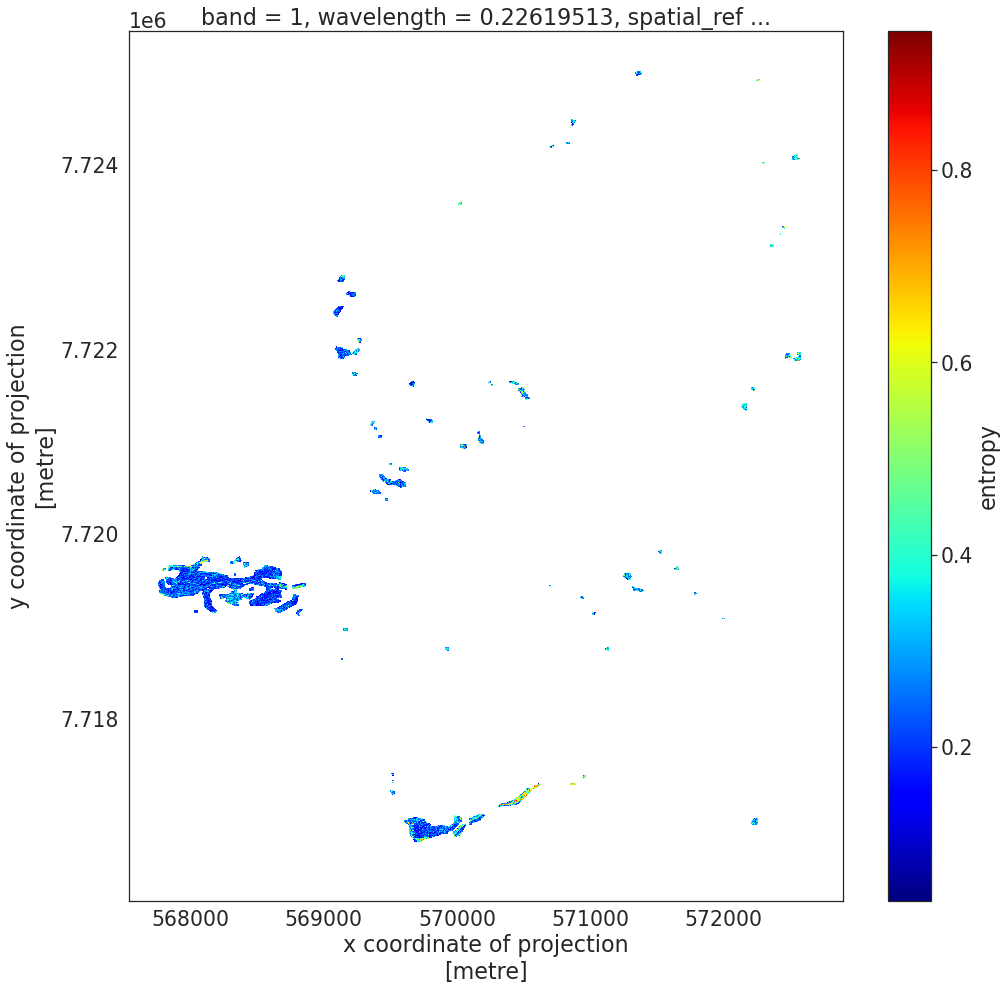

In [193]:
ds_l.where((ds_l['mask_Orca'] == True)).entropy.sel(time=2019).plot(cmap='jet')

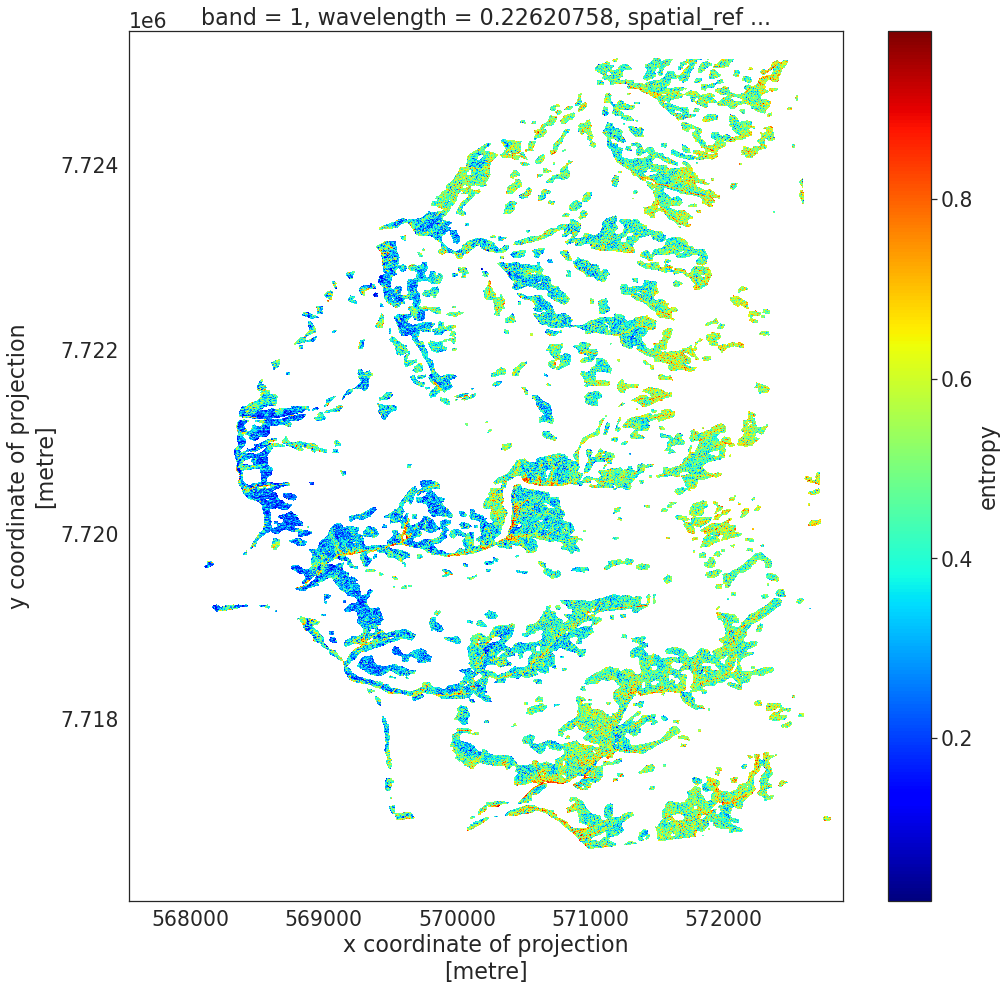

In [194]:
ds_l.where((ds_l['mask_Plove_+Jae'] == True)).entropy.sel(time=2018).plot(cmap='jet')

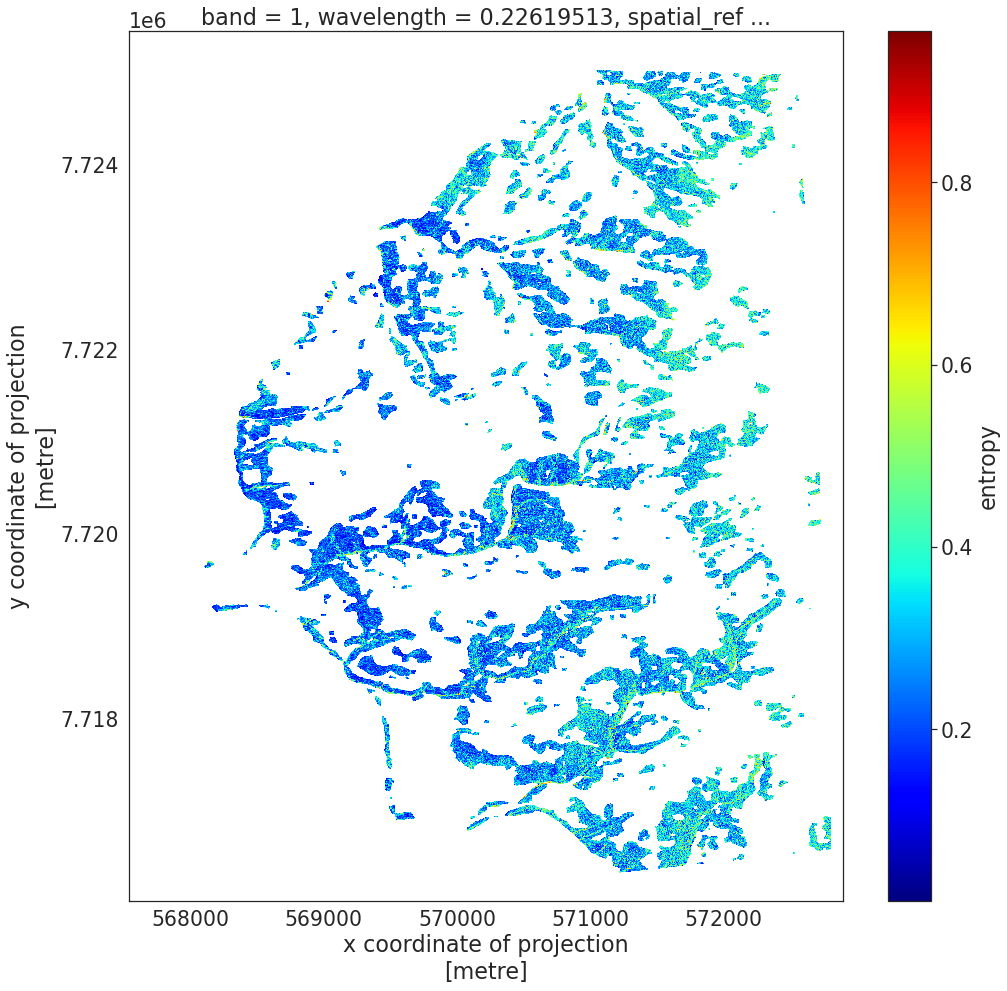

In [195]:
ds_l.where((ds_l['mask_Plove_+Jae'] == True)).entropy.sel(time=2019).plot(cmap='jet')

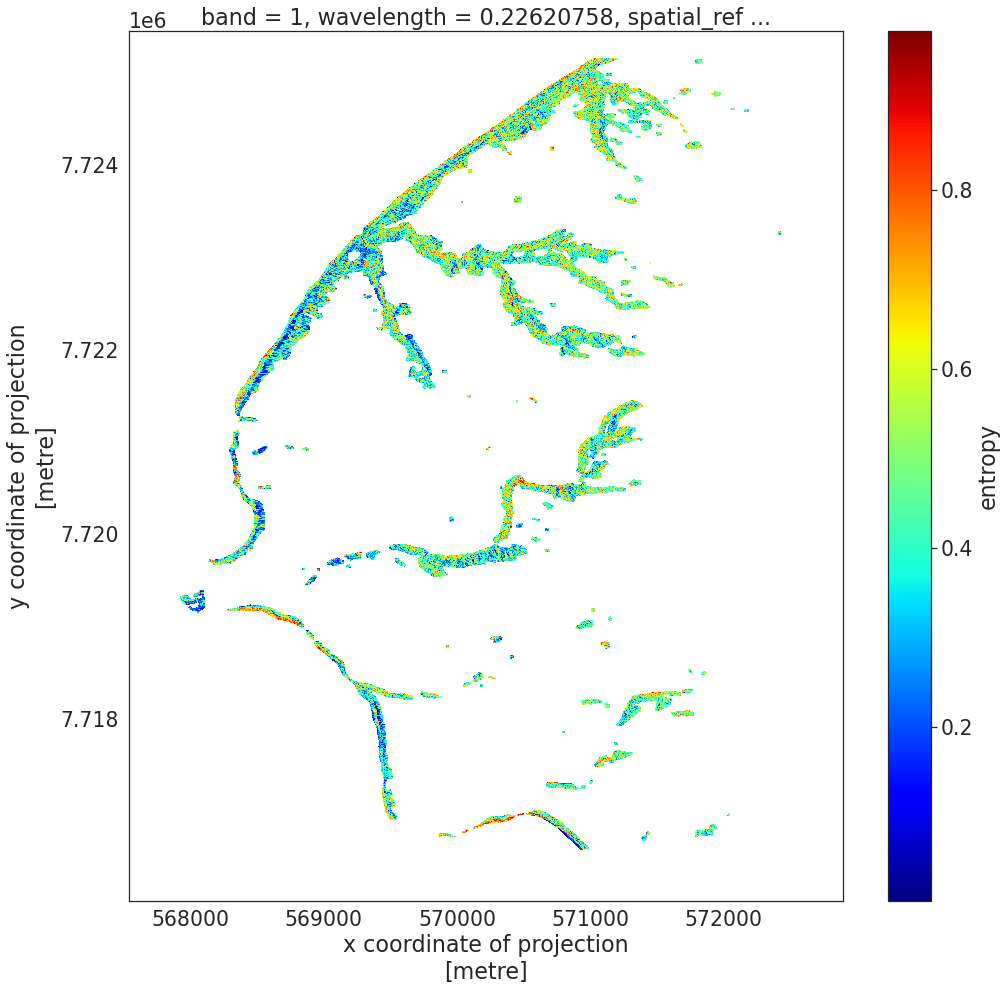

In [196]:
ds_l.where((ds_l['mask_Thrasher'] == True)).entropy.sel(time=2018).plot(cmap='jet')

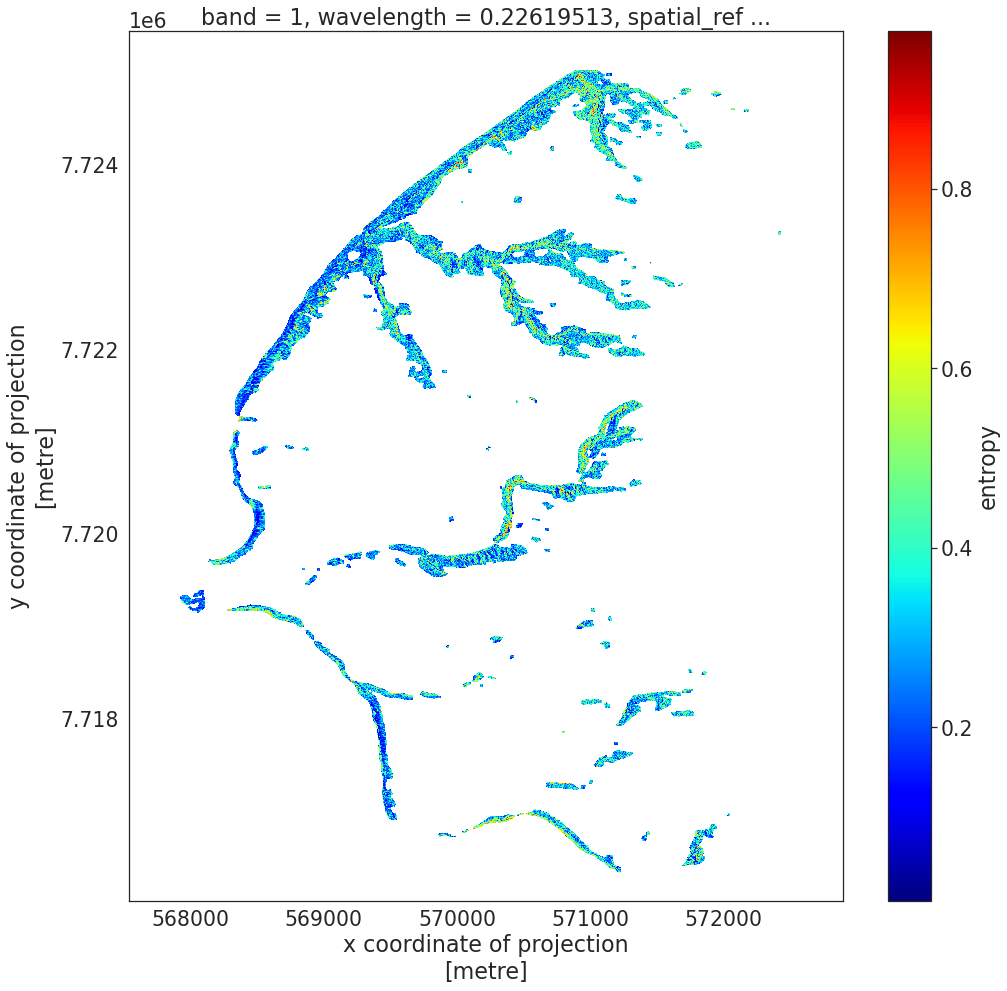

In [197]:
ds_l.where((ds_l['mask_Thrasher'] == True)).entropy.sel(time=2019).plot(cmap='jet')

In [49]:
ds_l_df = ds_l.to_dataframe()
ds_s_df = ds_s.to_dataframe()

In [55]:
# ds_l_df[ds_l_df["mask_Avadlek"] == True]

ds_l_df.loc[ds_l_df['mask_Avadlek']==1,'UnitName'] = 'White'
ds_l_df

offnadir  entropy  anisotropy  alpha  \
band time x             y                                                    
1    2018 567539.538173 7.725448e+06       NaN      NaN         NaN    NaN   
                        7.725447e+06       NaN      NaN         NaN    NaN   
                        7.725446e+06       NaN      NaN         NaN    NaN   
                        7.725445e+06       NaN      NaN         NaN    NaN   
                        7.725444e+06       NaN      NaN         NaN    NaN   
...                                        ...      ...         ...    ...   
     2019 572893.538173 7.716033e+06       NaN      NaN         NaN    NaN   
                        7.716032e+06       NaN      NaN         NaN    NaN   
                        7.716031e+06       NaN      NaN         NaN    NaN   
                        7.716030e+06       NaN      NaN         NaN    NaN   
                        7.716029e+06       NaN      NaN         NaN    NaN   

                                      p_hhvv  ph_diff_hhvv  aoi  mask_valid  \
band time x             y                                                     
1    2018 567539.538173 7.725448e+06     NaN           NaN  NaN           0   
                        7.725447e+06     NaN           NaN  NaN           0   
                        7.725446e+06     NaN           NaN  NaN           0   
                        7.725445e+06     NaN           NaN  NaN           0   
                        7.725444e+06     NaN           NaN  NaN           0   
...                                      ...           ...  ...         ...   
     2019 572893.538173 7.716033e+06     NaN           NaN  NaN           0   
                        7.716032e+06     NaN           NaN  NaN           0   
                        7.716031e+06     NaN           NaN  NaN           0   
                        7.716030e+06     NaN           NaN  NaN           0   
                        7.716029e+06     NaN           NaN  NaN           0   

                                      mask_Avadlek  mask_Guillemot  \
band time x             y                                            
1    2018 567539.538173 7.725448e+06             0               0   
                        7.725447e+06             0               0   
                        7.725446e+06             0               0   
                        7.725445e+06             0               0   
                        7.725444e+06             0               0   
...                                            ...             ...   
     2019 572893.538173 7.716033e+06             0               0   
                        7.716032e+06             0               0   
                        7.716031e+06             0               0   
                        7.716030e+06             0               0   
                        7.716029e+06             0               0   

                                      mask_Herschel  mask_Komakuk  mask_Orca  \
band time x             y                                                      
1    2018 567539.538173 7.725448e+06              0             0          0   
                        7.725447e+06              0             0          0   
                        7.725446e+06              0             0          0   
                        7.725445e+06              0             0          0   
                        7.725444e+06              0             0          0   
...                                             ...           ...        ...   
     2019 572893.538173 7.716033e+06              0             1          0   
                        7.716032e+06              0             1          0   
                        7.716031e+06              0             1          0   
                        7.716030e+06              0             1          0   
                        7.716029e+06              0             1          0   

                                      mask_

In [52]:
unit_masks = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove_+Jae', 'Thrasher']
unit_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']

for UnitName, UnitMask in zip(unit_names, unit_masks):
    print(UnitName, UnitMask)
    ds_l_df.loc[ds_l_df['mask_' + UnitMask ]==1,'UnitName'] = UnitName
    ds_s_df.loc[ds_s_df['mask_' + UnitMask ]==1,'UnitName'] = UnitName


Avadlek Avadlek
Guillemot Guillemot
Herschel Herschel
Komakuk Komakuk
Orca Orca
Plove+Jae Plove_+Jae
Thrasher Thrasher


In [69]:
overlap_classes_l = ds_l_df['mask_' + unit_masks[0] ] + \
    ds_l_df['mask_' + unit_masks[1] ] + \
    ds_l_df['mask_' + unit_masks[2] ] + \
    ds_l_df['mask_' + unit_masks[3] ] + \
    ds_l_df['mask_' + unit_masks[4] ] + \
    ds_l_df['mask_' + unit_masks[5] ] > 1
ds_l_df.loc[overlap_classes_l==1,'UnitName'] = np.NaN 

overlap_classes_s = ds_s_df['mask_' + unit_masks[0] ] + \
    ds_s_df['mask_' + unit_masks[1] ] + \
    ds_s_df['mask_' + unit_masks[2] ] + \
    ds_s_df['mask_' + unit_masks[3] ] + \
    ds_s_df['mask_' + unit_masks[4] ] + \
    ds_s_df['mask_' + unit_masks[5] ] > 1

ds_s_df.loc[overlap_classes_s==1,'UnitName'] = np.NaN 

np.count_nonzero(overlap_classes_l), np.count_nonzero(overlap_classes_s)

(1034836, 1062142)

In [70]:
ds_l_df

offnadir  entropy  anisotropy  alpha  \
band time x             y                                                    
1    2018 567539.538173 7.725448e+06       NaN      NaN         NaN    NaN   
                        7.725447e+06       NaN      NaN         NaN    NaN   
                        7.725446e+06       NaN      NaN         NaN    NaN   
                        7.725445e+06       NaN      NaN         NaN    NaN   
                        7.725444e+06       NaN      NaN         NaN    NaN   
...                                        ...      ...         ...    ...   
     2019 572893.538173 7.716033e+06       NaN      NaN         NaN    NaN   
                        7.716032e+06       NaN      NaN         NaN    NaN   
                        7.716031e+06       NaN      NaN         NaN    NaN   
                        7.716030e+06       NaN      NaN         NaN    NaN   
                        7.716029e+06       NaN      NaN         NaN    NaN   

                                      p_hhvv  ph_diff_hhvv  aoi  mask_valid  \
band time x             y                                                     
1    2018 567539.538173 7.725448e+06     NaN           NaN  NaN           0   
                        7.725447e+06     NaN           NaN  NaN           0   
                        7.725446e+06     NaN           NaN  NaN           0   
                        7.725445e+06     NaN           NaN  NaN           0   
                        7.725444e+06     NaN           NaN  NaN           0   
...                                      ...           ...  ...         ...   
     2019 572893.538173 7.716033e+06     NaN           NaN  NaN           0   
                        7.716032e+06     NaN           NaN  NaN           0   
                        7.716031e+06     NaN           NaN  NaN           0   
                        7.716030e+06     NaN           NaN  NaN           0   
                        7.716029e+06     NaN           NaN  NaN           0   

                                      mask_Avadlek  mask_Guillemot  \
band time x             y                                            
1    2018 567539.538173 7.725448e+06             0               0   
                        7.725447e+06             0               0   
                        7.725446e+06             0               0   
                        7.725445e+06             0               0   
                        7.725444e+06             0               0   
...                                            ...             ...   
     2019 572893.538173 7.716033e+06             0               0   
                        7.716032e+06             0               0   
                        7.716031e+06             0               0   
                        7.716030e+06             0               0   
                        7.716029e+06             0               0   

                                      mask_Herschel  mask_Komakuk  mask_Orca  \
band time x             y                                                      
1    2018 567539.538173 7.725448e+06              0             0          0   
                        7.725447e+06              0             0          0   
                        7.725446e+06              0             0          0   
                        7.725445e+06              0             0          0   
                        7.725444e+06              0             0          0   
...                                             ...           ...        ...   
     2019 572893.538173 7.716033e+06              0             1          0   
                        7.716032e+06              0             1          0   
                        7.716031e+06              0             1          0   
                        7.716030e+06              0             1          0   
                        7.716029e+06              0             1          0   

                                      mask_

In [71]:
ds_s_df

offnadir  entropy  anisotropy  alpha  \
band time x             y                                                    
1    2018 567534.752664 7.725992e+06       NaN      NaN         NaN    NaN   
                        7.725991e+06       NaN      NaN         NaN    NaN   
                        7.725990e+06       NaN      NaN         NaN    NaN   
                        7.725989e+06       NaN      NaN         NaN    NaN   
                        7.725988e+06       NaN      NaN         NaN    NaN   
...                                        ...      ...         ...    ...   
     2019 572893.752664 7.715847e+06       NaN      NaN         NaN    NaN   
                        7.715846e+06       NaN      NaN         NaN    NaN   
                        7.715845e+06       NaN      NaN         NaN    NaN   
                        7.715844e+06       NaN      NaN         NaN    NaN   
                        7.715843e+06       NaN      NaN         NaN    NaN   

                                      p_hhvv  ph_diff_hhvv  aoi  mask_valid  \
band time x             y                                                     
1    2018 567534.752664 7.725992e+06     NaN           NaN  NaN           0   
                        7.725991e+06     NaN           NaN  NaN           0   
                        7.725990e+06     NaN           NaN  NaN           0   
                        7.725989e+06     NaN           NaN  NaN           0   
                        7.725988e+06     NaN           NaN  NaN           0   
...                                      ...           ...  ...         ...   
     2019 572893.752664 7.715847e+06     NaN           NaN  NaN           0   
                        7.715846e+06     NaN           NaN  NaN           0   
                        7.715845e+06     NaN           NaN  NaN           0   
                        7.715844e+06     NaN           NaN  NaN           0   
                        7.715843e+06     NaN           NaN  NaN           0   

                                      mask_Avadlek  mask_Guillemot  \
band time x             y                                            
1    2018 567534.752664 7.725992e+06             0               0   
                        7.725991e+06             0               0   
                        7.725990e+06             0               0   
                        7.725989e+06             0               0   
                        7.725988e+06             0               0   
...                                            ...             ...   
     2019 572893.752664 7.715847e+06             0               0   
                        7.715846e+06             0               0   
                        7.715845e+06             0               0   
                        7.715844e+06             0               0   
                        7.715843e+06             0               0   

                                      mask_Herschel  mask_Komakuk  mask_Orca  \
band time x             y                                                      
1    2018 567534.752664 7.725992e+06              0             0          0   
                        7.725991e+06              0             0          0   
                        7.725990e+06              0             0          0   
                        7.725989e+06              0             0          0   
                        7.725988e+06              0             0          0   
...                                             ...           ...        ...   
     2019 572893.752664 7.715847e+06              0             1          0   
                        7.715846e+06              0             1          0   
                        7.715845e+06              0             1          0   
                        7.715844e+06              0             1          0   
                        7.715843e+06              0             1          0   

                                      mask_

In [72]:
ds_l_df[ds_l_df.mask_Komakuk == True]

offnadir   entropy  anisotropy  \
band time x             y                                               
1    2018 568386.538173 7.720689e+06  28.234934  0.444224    0.384397   
                        7.720688e+06  28.234055  0.392702    0.218280   
                        7.720687e+06  28.232996  0.413579    0.321365   
                        7.720686e+06  28.231731  0.442198    0.263950   
                        7.720685e+06  28.230320  0.382884    0.389252   
...                                         ...       ...         ...   
     2019 572893.538173 7.716033e+06        NaN       NaN         NaN   
                        7.716032e+06        NaN       NaN         NaN   
                        7.716031e+06        NaN       NaN         NaN   
                        7.716030e+06        NaN       NaN         NaN   
                        7.716029e+06        NaN       NaN         NaN   

                                          alpha    p_hhvv  ph_diff_hhvv  \
band time x             y                                                 
1    2018 568386.538173 7.720689e+06  20.804824  1.253720     -9.381011   
                        7.720688e+06  17.423425  1.128348     -9.593571   
                        7.720687e+06  16.843748  1.322328     -4.866321   
                        7.720686e+06  18.503353  1.348472     -6.736529   
                        7.720685e+06  16.782249  1.344833     -8.764470   
...                                         ...       ...           ...   
     2019 572893.538173 7.716033e+06        NaN       NaN           NaN   
                        7.716032e+06        NaN       NaN           NaN   
                        7.716031e+06        NaN       NaN           NaN   
                        7.716030e+06        NaN       NaN           NaN   
                        7.716029e+06        NaN       NaN           NaN   

                                            aoi  mask_valid  mask_Avadlek  \
band time x             y                                                   
1    2018 568386.538173 7.720689e+06  19.678505           1             0   
                        7.720688e+06  19.578299           1             0   
                        7.720687e+06  19.474911           1             0   
                        7.720686e+06  19.370625           1             0   
                        7.720685e+06  19.268911           1             0   
...                                         ...         ...           ...   
     2019 572893.538173 7.716033e+06        NaN           0             0   
                        7.716032e+06        NaN           0             0   
                        7.716031e+06        NaN           0             0   
                        7.716030e+06        NaN           0             0   
                        7.716029e+06        NaN           0             0   

                                      mask_Guillemot  mask_Herschel  \
band time x             y                                             
1    2018 568386.538173 7.720689e+06               0              0   
                        7.720688e+06               0              0   
                        7.720687e+06               0              0   
                        7.720686e+06               0              0   
                        7.720685e+06               0              0   
...                                              ...            ...   
     2019 572893.538173 7.716033e+06               0              0   
                        7.716032e+06               0              0   
                        7.716031e+06               0              0   
                        7.716030e+06               0              0   
                        7.716029e+06               0              0   

                                      mask_Komakuk  mask_Orca  \
band time x             y                                       
1    2018 568386.538173 7.720689e+06             1       

In [79]:
ds_l_df.loc[~pd.isnull(ds_l_df.UnitName)]

offnadir  entropy  anisotropy  alpha  \
band time x             y                                                    
1    2018 567539.538173 7.720235e+06       NaN      NaN         NaN    NaN   
                        7.720234e+06       NaN      NaN         NaN    NaN   
                        7.720233e+06       NaN      NaN         NaN    NaN   
                        7.720232e+06       NaN      NaN         NaN    NaN   
                        7.720231e+06       NaN      NaN         NaN    NaN   
...                                        ...      ...         ...    ...   
     2019 572893.538173 7.716033e+06       NaN      NaN         NaN    NaN   
                        7.716032e+06       NaN      NaN         NaN    NaN   
                        7.716031e+06       NaN      NaN         NaN    NaN   
                        7.716030e+06       NaN      NaN         NaN    NaN   
                        7.716029e+06       NaN      NaN         NaN    NaN   

                                      p_hhvv  ph_diff_hhvv  aoi  mask_valid  \
band time x             y                                                     
1    2018 567539.538173 7.720235e+06     NaN           NaN  NaN           0   
                        7.720234e+06     NaN           NaN  NaN           0   
                        7.720233e+06     NaN           NaN  NaN           0   
                        7.720232e+06     NaN           NaN  NaN           0   
                        7.720231e+06     NaN           NaN  NaN           0   
...                                      ...           ...  ...         ...   
     2019 572893.538173 7.716033e+06     NaN           NaN  NaN           0   
                        7.716032e+06     NaN           NaN  NaN           0   
                        7.716031e+06     NaN           NaN  NaN           0   
                        7.716030e+06     NaN           NaN  NaN           0   
                        7.716029e+06     NaN           NaN  NaN           0   

                                      mask_Avadlek  mask_Guillemot  \
band time x             y                                            
1    2018 567539.538173 7.720235e+06             1               0   
                        7.720234e+06             1               0   
                        7.720233e+06             1               0   
                        7.720232e+06             1               0   
                        7.720231e+06             1               0   
...                                            ...             ...   
     2019 572893.538173 7.716033e+06             0               0   
                        7.716032e+06             0               0   
                        7.716031e+06             0               0   
                        7.716030e+06             0               0   
                        7.716029e+06             0               0   

                                      mask_Herschel  mask_Komakuk  mask_Orca  \
band time x             y                                                      
1    2018 567539.538173 7.720235e+06              0             0          0   
                        7.720234e+06              0             0          0   
                        7.720233e+06              0             0          0   
                        7.720232e+06              0             0          0   
                        7.720231e+06              0             0          0   
...                                             ...           ...        ...   
     2019 572893.538173 7.716033e+06              0             1          0   
                        7.716032e+06              0             1          0   
                        7.716031e+06              0             1          0   
                        7.716030e+06              0             1          0   
                        7.716029e+06              0             1          0   

                                      mask_

In [36]:
tips = sns.load_dataset("tips")
sns.histplot(tips, x='total_bill', y='tip')
tips

total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]

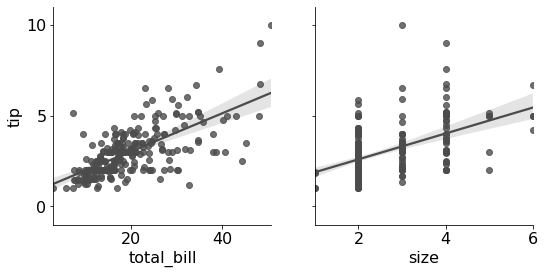

In [46]:
g = sns.PairGrid(tips, y_vars=["tip"], x_vars=["total_bill", "size"], height=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-1, 11), yticks=[0, 5, 10])

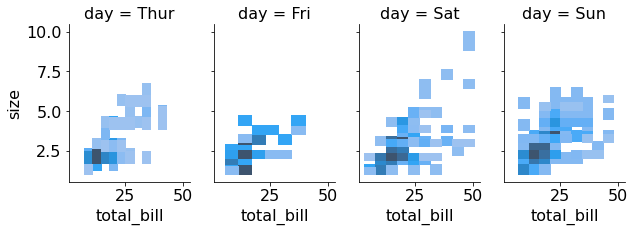

In [45]:
g = sns.FacetGrid(tips, col="day", height=3.5, aspect=.65)
g.map(sns.histplot, 'total_bill', 'tip')
g.map(sns.histplot, 'total_bill', 'size')


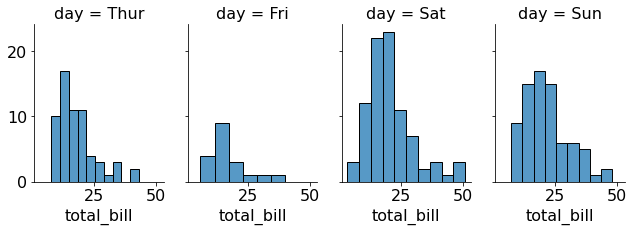

In [35]:
g = sns.FacetGrid(tips, col="day", height=3.5, aspect=.65)
g.map(sns.histplot, "total_bill")

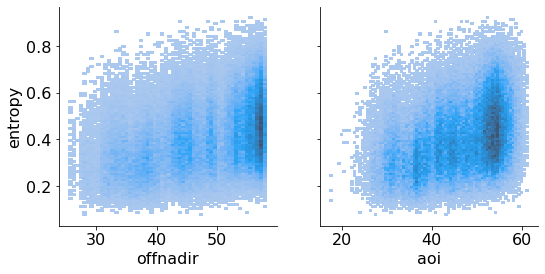

In [50]:
g = sns.PairGrid(ds_l_df[ds_l_df.mask_Herschel == True].sample(n=100000).reset_index(), y_vars=["entropy"], x_vars=["offnadir", "aoi"], height=4)
g.map(sns.histplot,  )

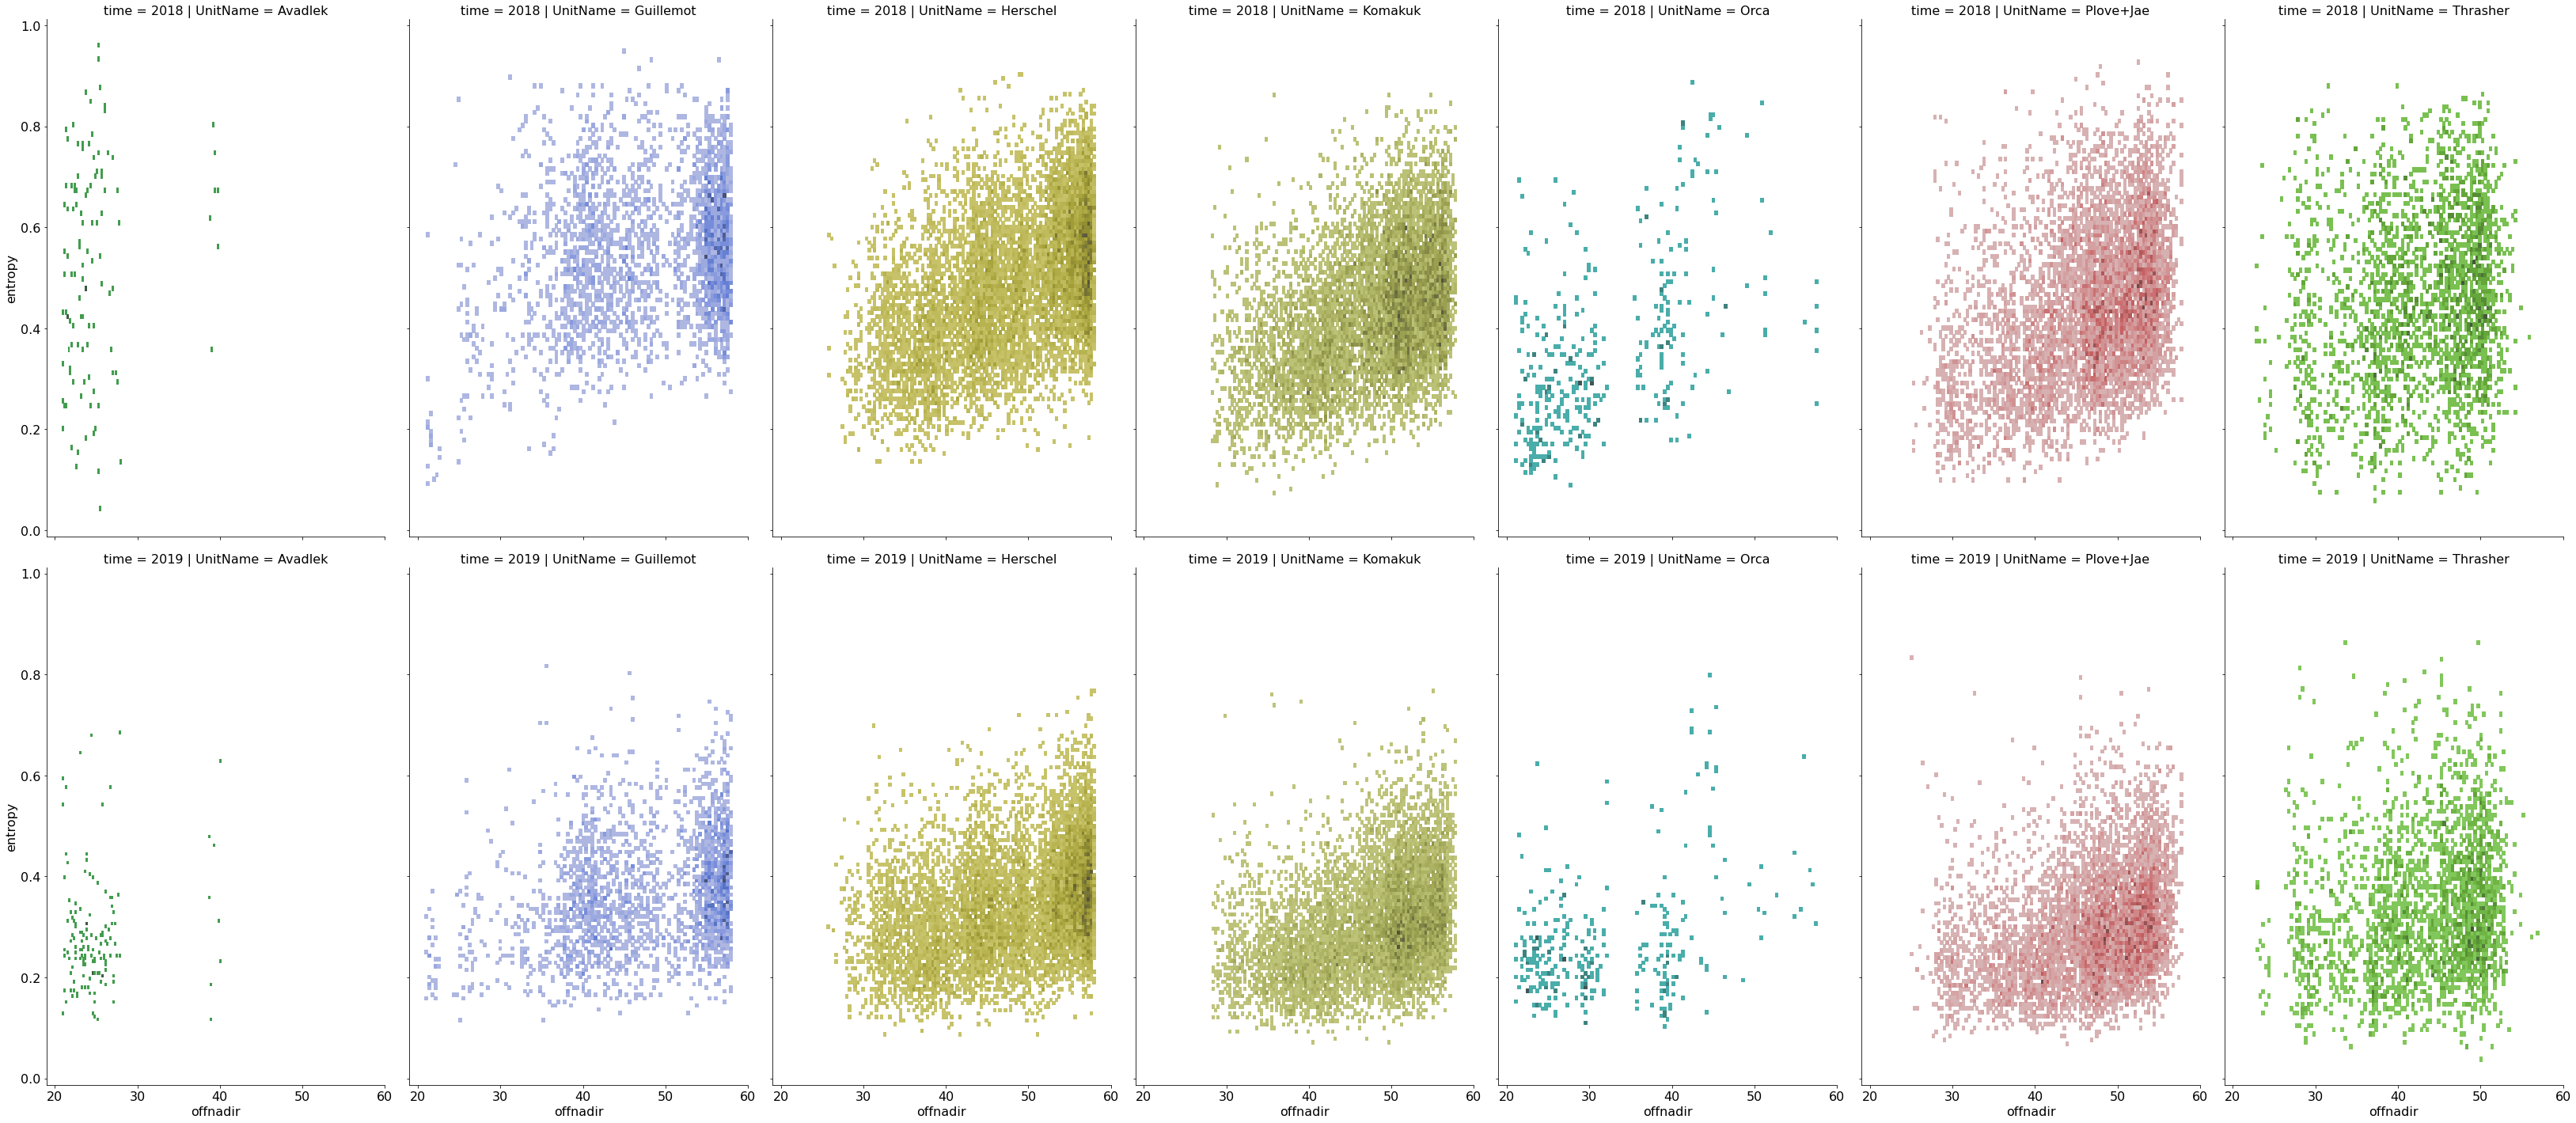

In [89]:
# g = sns.FacetGrid(ds_l_df[ds_l_df.mask_valid == True].sample(n=1000), col=['entropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv', 'anisotropy'],  row="offnadir")
g = sns.FacetGrid(ds_l_df.sample(n=100000).reset_index(), col='UnitName', row="time", height=10, aspect=.65, hue="UnitName", palette=ecological_colors, col_order=unit_names, hue_order=unit_names)
g.map(sns.histplot, 'offnadir', 'entropy', bins=100, palette=ecological_colors)


In [213]:
def plot_2dhist_sns(df, col='UnitName', row="time", x_hist='aoi', 
                    y_hist='entropy', x_y_label_dict=None, 
                    xlim=None, ylim=None):
    sns.set(font_scale=1.85)  # crazy big
    sns.set_style("white")

    df = df.reset_index()
    df = df.loc[~pd.isnull(df.UnitName)]
    g = sns.FacetGrid(df.reset_index(), col=col, row=row, height=6, aspect=1, 
                      hue="UnitName", palette=ecological_colors, 
                      col_order=unit_names, hue_order=unit_names, 
                      xlim=xlim, ylim=ylim)
    g.map(sns.histplot, x_hist, y_hist, bins=1000, )
    if x_y_label_dict is not None :
        g.set_axis_labels(x_y_label_dict[x_hist], x_y_label_dict[y_hist])

    return g


In [118]:
latex_label = {'entropy': 'Entropy (${H}_w$)', 
               'offnadir': 'offnadir [deg]',
               'anisotropy': 'Anisotropy (${H}_w$)', 
               'alpha': 'Alpha (${\\alpha}_{avg}$) [deg]',
               'p_hhvv': '${P}_{HHVV}$',
               'ph_diff_hhvv': 'CPD ${Phase}_{HHVV}$ [deg]',
               'aoi': 'AOI [deg]',}
latex_label["entropy"]

'Entropy (${H}_w$)'

In [154]:
print(file_name)

18prmasr0302_L


In [159]:
fig_save.joinpath('PNG', "2d_hist", str(prmasr_nc["L"]["18"][0].name[:-3]) + "_" + pol_key + ".png")

TypeError: can only concatenate str (not "set") to str

In [205]:
title = str(prmasr_nc["L"]["18"][0].name)

In [206]:
print( title + "_" + pol_key + ".png" )

TypeError: can only concatenate str (not "set") to str

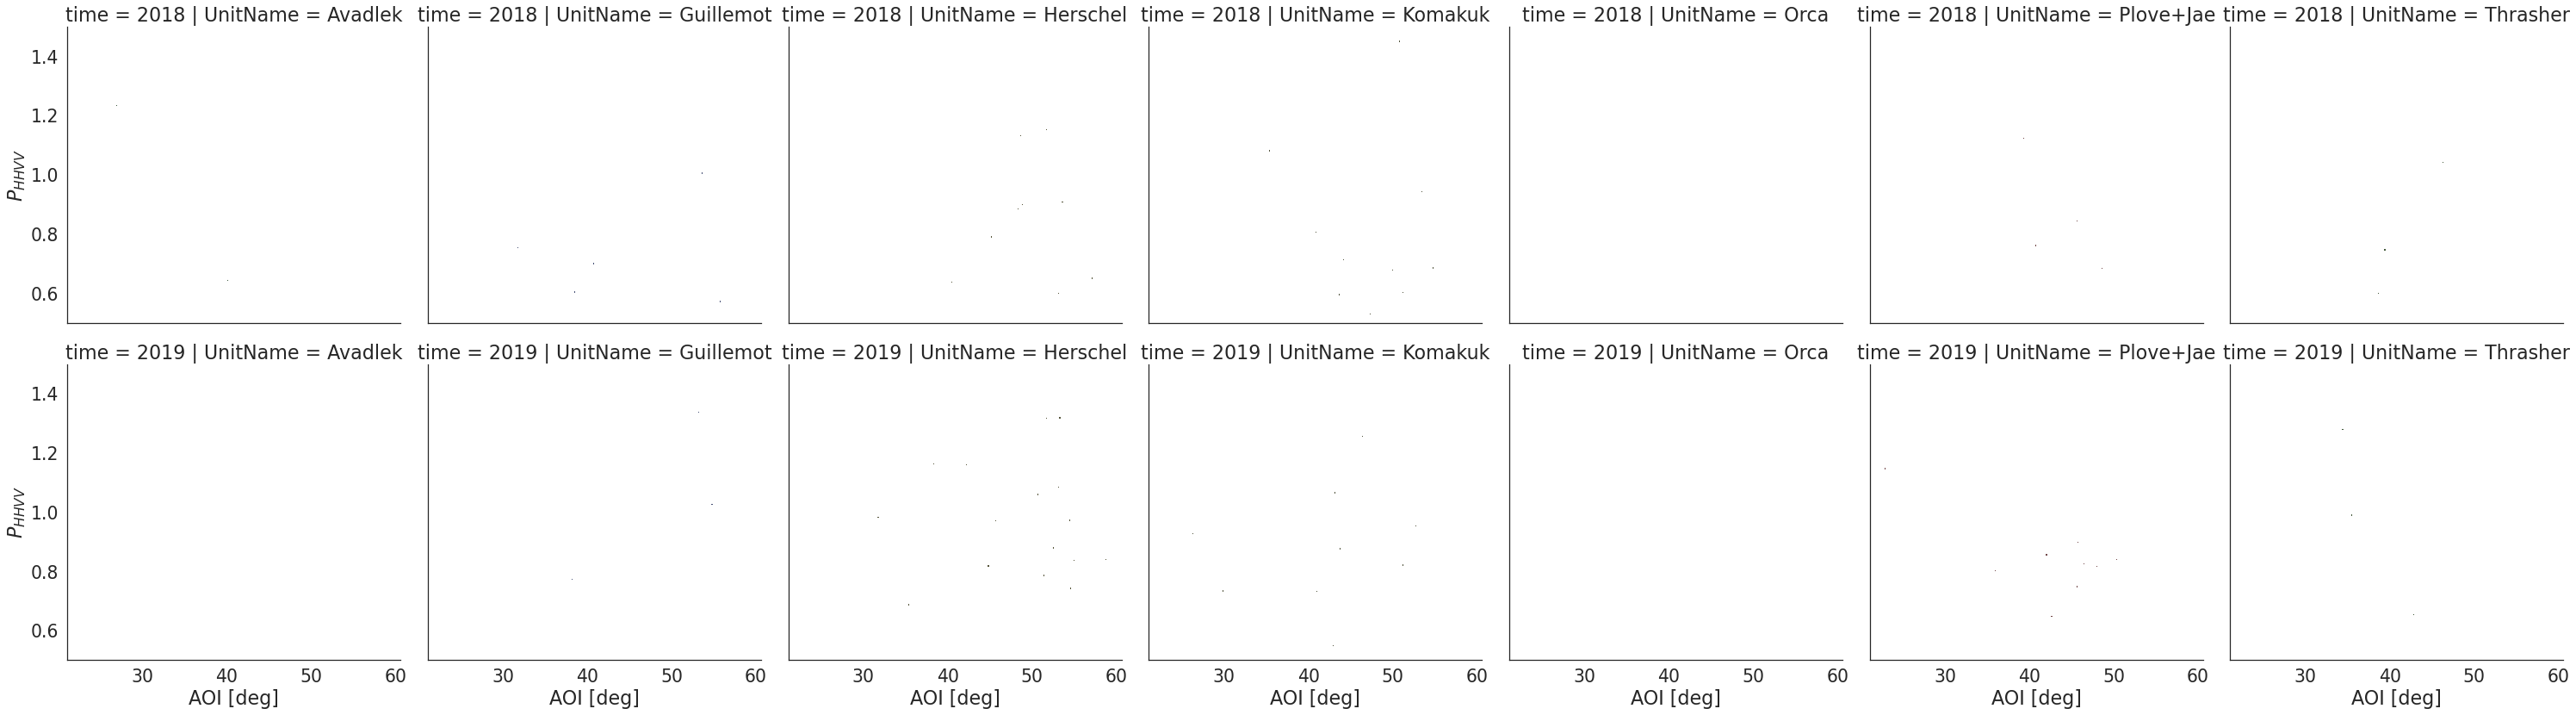

In [217]:
file_name = prmasr_nc["L"]["18"][0].name[:-3]
pol_key_name = pol_key[0]
fig = plot_2dhist_sns(df=ds_l_df.reset_index().sample(100), 
                 x_hist='aoi', y_hist='p_hhvv', ylim=(0.5,1.5),
                col='UnitName', row="time", x_y_label_dict=latex_label)

# fig.savefig(fig_save.joinpath('PNG', "2d_hist", file_name + "_" + pol_key_name + ".png"))
# plt.clf()
# phase_diff -20, 40

In [210]:
pol_key = ['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv']
pol_key

for item in pol_key:
    file_name = prmasr_nc["L"]["18"][0].name[:-3] + "_" + prmasr_nc["L"]["19"][0].name[:-3]
    pol_key_name = item
    fig = plot_2dhist_sns(df=ds_l_df, 
                     x_hist='aoi', y_hist=pol_key_name,
                    col='UnitName', row="time", x_y_label_dict=latex_label)

    fig.savefig(fig_save.joinpath('PNG', "2d_hist", file_name + "_" + pol_key_name + ".png"))
    plt.clf()

<Figure size 3024x864 with 0 Axes>

<Figure size 3024x864 with 0 Axes>

<Figure size 3024x864 with 0 Axes>

<Figure size 3024x864 with 0 Axes>

<Figure size 3024x864 with 0 Axes>

In [211]:
for item in pol_key:
    print(pol_key)
    file_name = prmasr_nc["S"]["18"][0].name[:-3] + "_" + prmasr_nc["S"]["19"][0].name[:-3]
    pol_key_name = item
    fig = plot_2dhist_sns(df=ds_l_df, 
                     x_hist='aoi', y_hist=pol_key_name,
                    col='UnitName', row="time", x_y_label_dict=latex_label)

    fig.savefig(fig_save.joinpath('PNG', "2d_hist", file_name + "_" + pol_key_name + ".png"))
    plt.clf()

['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv']
['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv']
['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv']
['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv']
['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv']


<Figure size 3024x864 with 0 Axes>

<Figure size 3024x864 with 0 Axes>

<Figure size 3024x864 with 0 Axes>

<Figure size 3024x864 with 0 Axes>

<Figure size 3024x864 with 0 Axes>

In [ ]:
pol_key = ['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv']
pol_key

x_hist='alpha'

for item in pol_key:
    if x_hist != item:
        file_name = prmasr_nc["L"]["18"][0].name[:-3] + "_" + prmasr_nc["L"]["19"][0].name[:-3]
        pol_key_name = item
        fig = plot_2dhist_sns(df=ds_l_df, 
                         x_hist=x_hist, y_hist=pol_key_name,
                        col='UnitName', row="time", x_y_label_dict=latex_label)

        fig.savefig(fig_save.joinpath('PNG', "2d_hist", file_name + "_" + 
                                      pol_key_name + '-' + x_hist+ ".png"))
        plt.clf()
    
for item in pol_key:
    if x_hist != item:
        file_name = prmasr_nc["S"]["18"][0].name[:-3] + "_" + prmasr_nc["S"]["19"][0].name[:-3]
        pol_key_name = item
        fig = plot_2dhist_sns(df=ds_l_df, 
                         x_hist=x_hist, y_hist=pol_key_name,
                        col='UnitName', row="time", x_y_label_dict=latex_label)

        fig.savefig(fig_save.joinpath('PNG', "2d_hist", file_name + "_" + 
                                      pol_key_name + '-' + x_hist+ ".png"))
        plt.clf()

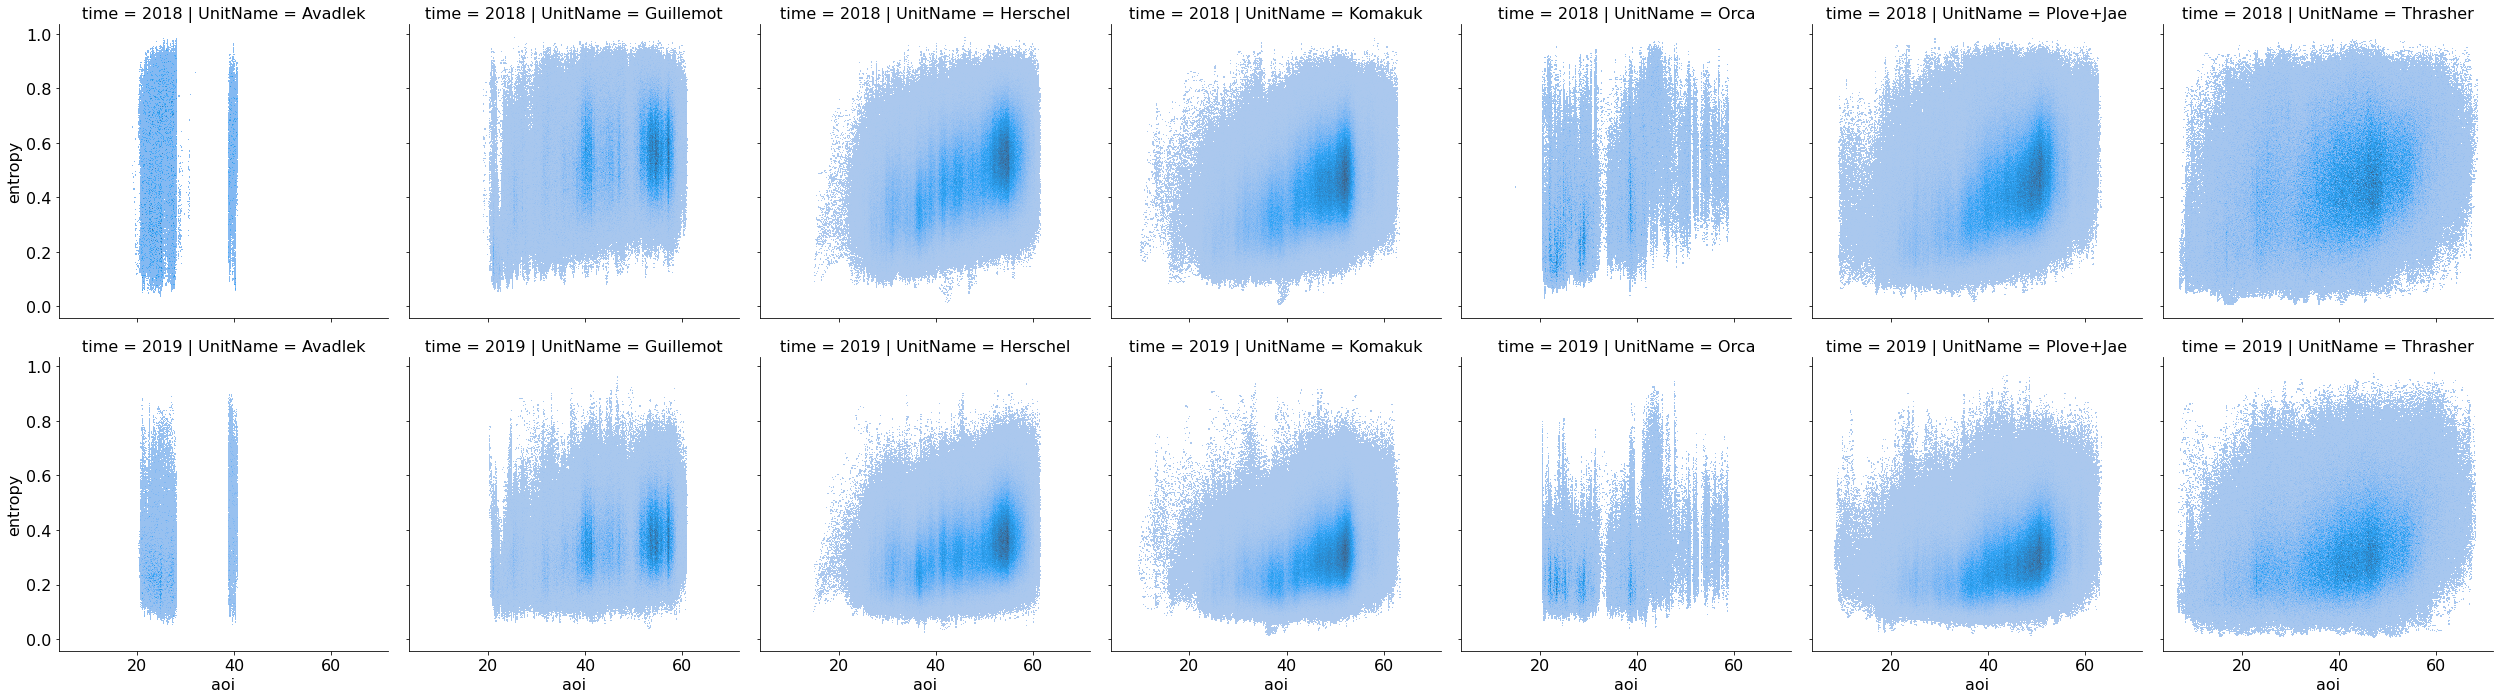

In [91]:
plot_2dhist_sns(df=ds_l_df, col='UnitName', row="time",)

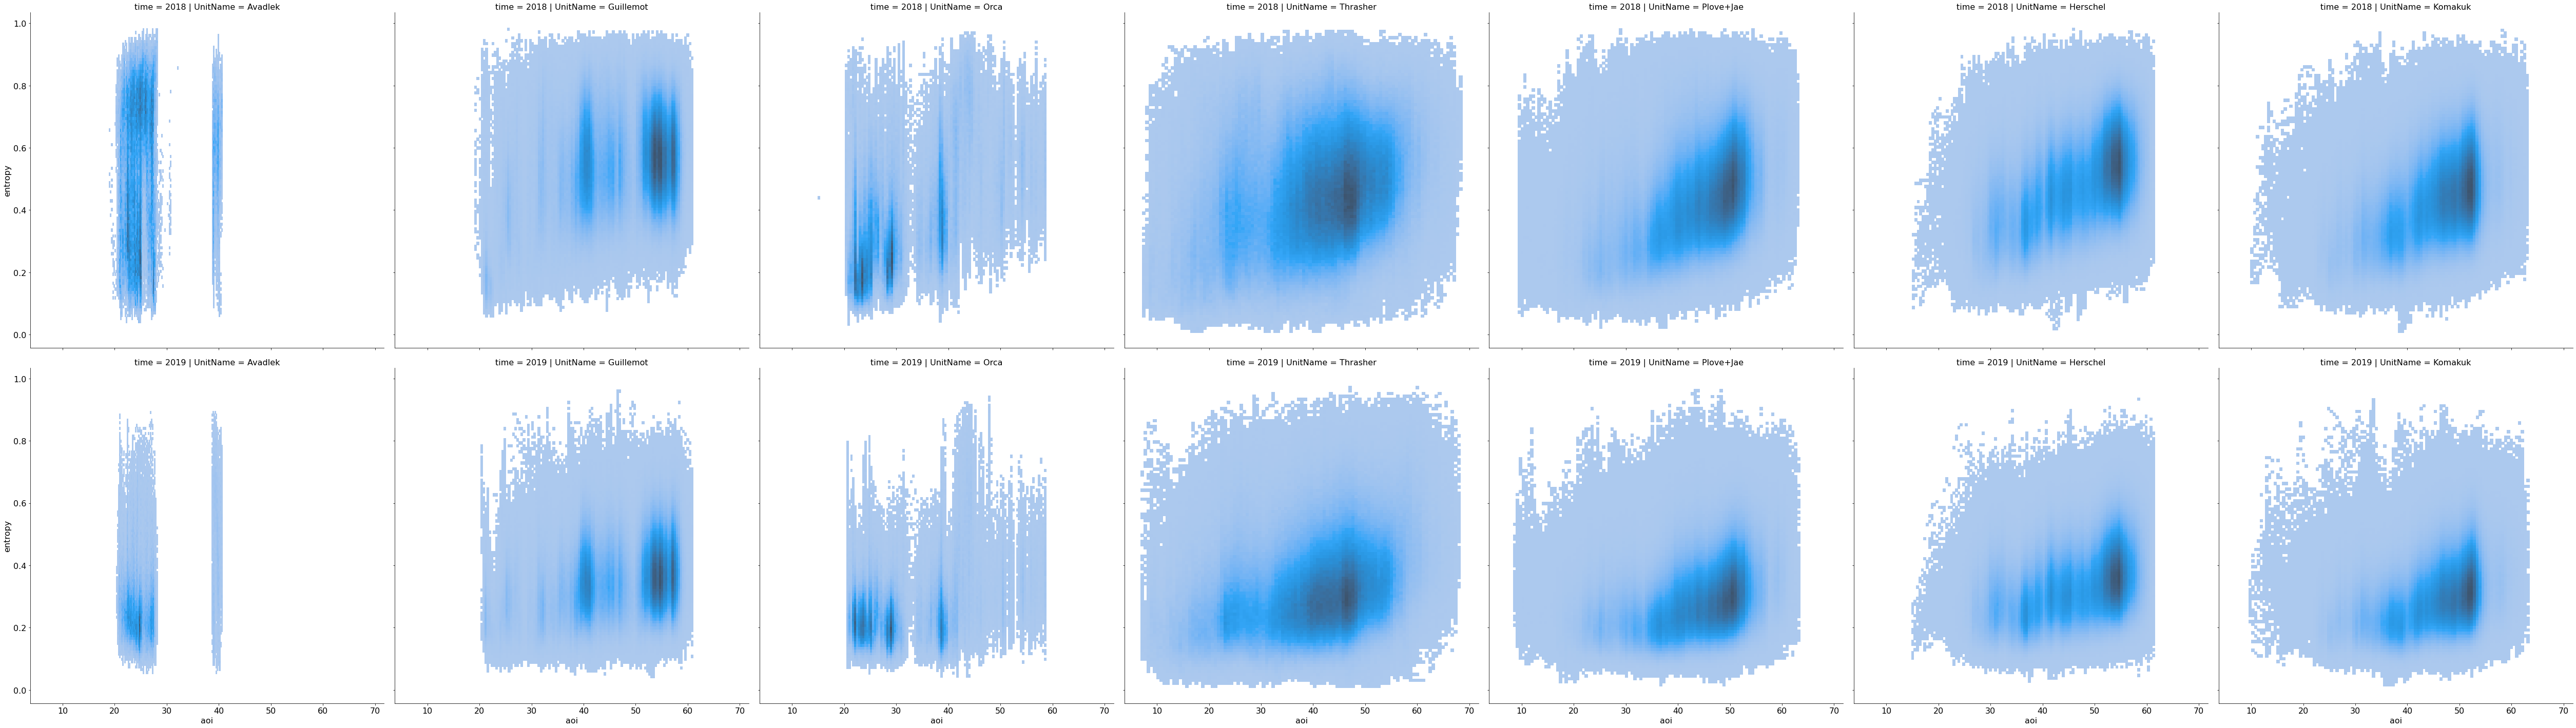

In [78]:
# g = sns.FacetGrid(ds_l_df[ds_l_df.mask_valid == True].sample(n=1000), col=['entropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv', 'anisotropy'],  row="offnadir")
g = sns.FacetGrid(ds_l_df.reset_index(), col='UnitName', row="time", height=10, aspect=1, palette=ecological_colors)
g.map(sns.histplot, 'aoi', 'entropy', bins=100, )


<AxesSubplot:xlabel='offnadir', ylabel='entropy'>

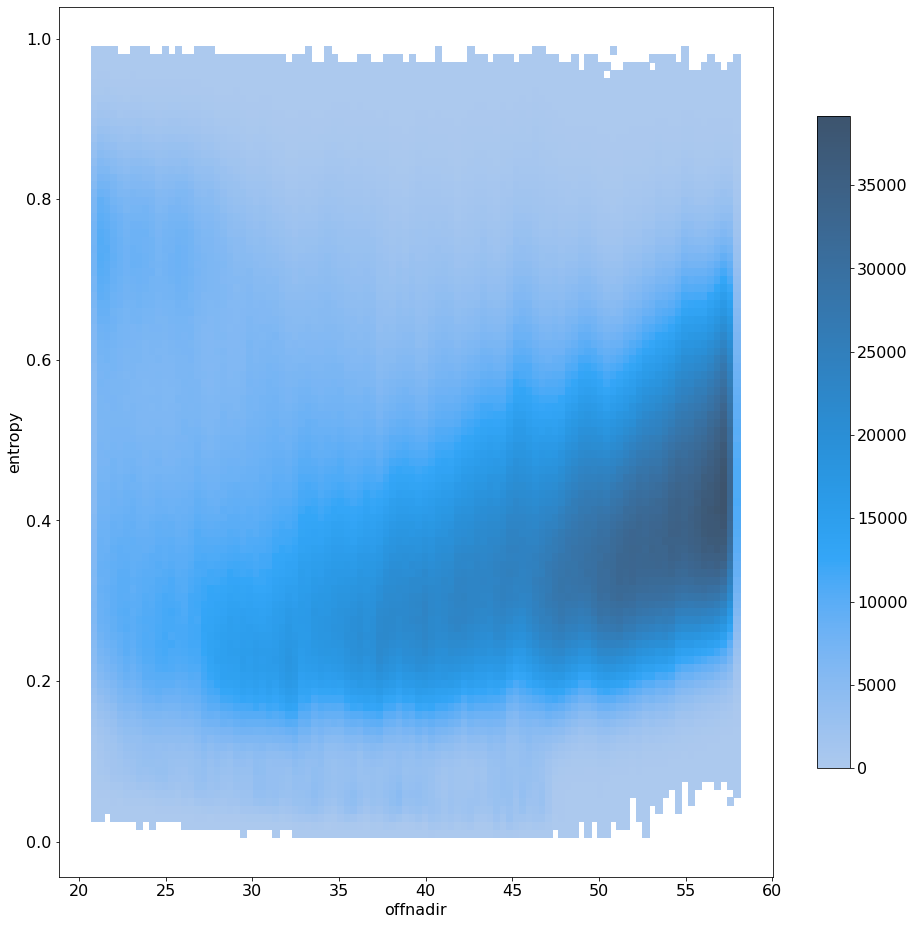

In [31]:
sns.histplot(
    ds_l_df[ds_l_df.mask_valid == True], x="offnadir", y="entropy",
    bins=100, discrete=(False, False), log_scale=(False, False),
    cbar=True, cbar_kws=dict(shrink=.75),
)

In [ ]:
sns.histplot(
    ds_l_df[ds_l_df.mask_valid == True], x="offnadir", y="entropy",
    bins=30, discrete=(False, False), log_scale=(False, False),
    cbar=True, cbar_kws=dict(shrink=.75),
)